# Setting Up Environment

In [1]:
import math, os, re, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, AlphaDropout
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.callbacks import EarlyStopping

tqdm.pandas()
tf.random.set_seed(42)

%matplotlib inline

os.listdir()

['__notebook__.ipynb']

In [2]:
print(tf.__version__)

2.4.1


# Data Preparation

In [3]:
raw_data = pd.read_csv('../input/bt4222-project/modelling_dataset.csv')
raw_data = pd.concat([raw_data.pop('Unit Price ($ PSM)'), raw_data], axis=1)

raw_data

,Unit Price ($ PSM),Area (SQM),Floor Number,PPI,Average Cases Per Year,Nearest Primary School,nearest_station_distance,Remaining Lease,Ang Mo Kio,Bedok,...,Yishun,BLUE,BROWN,GREEN,LRT,PURPLE,RED,YELLOW,Apartment,Executive Condominium
0,6316.0,95.0,1.0,124.3,33,705.752731,1207.822015,87.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13833.0,138.0,1.0,124.3,58,1233.947139,768.529003,88.0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,8990.0,99.0,10.0,124.3,50,1039.586179,816.818037,80.0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,6306.0,111.0,6.0,124.3,33,509.516515,501.364218,80.0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,13934.0,122.0,10.0,124.3,58,1253.733260,554.491114,88.0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54669,8229.0,192.0,4.0,153.3,66,526.868822,464.021930,76.0,0,0,...,0,0,0,0,1,0,0,0,0,0
54670,7838.0,111.0,14.0,153.3,66,535.286185,490.669867,80.0,0,0,...,0,0,0,0,1,1,0,0,0,1
54671,13028.0,142.0,14.0,153.3,133,2075.609094,600.145285,72.0,0,0,...,0,0,0,0,0,0,0,1,0,0
54672,13931.0,58.0,6.0,153.3,51,397.651025,539.116552,91.0,0,0,...,0,1,0,0,0,0,0,0,0,0


# Train-Test Split

In [4]:
# Perform 70/30 train_test split
X = raw_data.iloc[:,1:].copy()
y = raw_data.iloc[:,0:1].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=42)
X_train

,Area (SQM),Floor Number,PPI,Average Cases Per Year,Nearest Primary School,nearest_station_distance,Remaining Lease,Ang Mo Kio,Bedok,Bishan,...,Yishun,BLUE,BROWN,GREEN,LRT,PURPLE,RED,YELLOW,Apartment,Executive Condominium
11187,129.0,9.0,139.2,66,313.319878,1514.605671,85.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18593,66.0,13.0,142.3,63,408.305136,1517.388799,84.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
27013,61.0,58.0,137.7,85,1529.338980,148.651892,86.0,0,0,0,...,0,1,0,1,0,0,1,1,1,0
39116,105.0,18.0,141.6,66,270.671774,225.750354,86.0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
6042,111.0,37.0,132.6,60,339.216214,258.201238,87.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44732,107.0,3.0,145.2,36,102.333066,622.895879,73.0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
54343,66.0,2.0,153.3,64,414.799433,805.354104,87.0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
38158,74.0,3.0,141.6,142,774.750823,466.130105,76.0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
860,91.0,14.0,124.3,133,658.187930,310.779399,83.0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


# Feature Scaling

In [5]:
def all_transform(X_train, X_test):
    all_features = list(X_train.columns)

    standardScale_vars = ['Area (SQM)',
                          'Floor Number',
                          'PPI',
                          'Average Cases Per Year',
                          'Nearest Primary School',
                          'nearest_station_distance']

    minMax_vars = ['Remaining Lease']

    remaining_features = [x for x in all_features if x not in standardScale_vars and x not in minMax_vars]

    s_scaler = StandardScaler()
    mm_scaler = MinMaxScaler()

    s_scaled = pd.DataFrame(s_scaler.fit_transform(X_train.loc[:, standardScale_vars].copy()), columns=standardScale_vars, index=X_train.index)
    mm_scaled = pd.DataFrame(mm_scaler.fit_transform(X_train.loc[:, minMax_vars].copy()), columns=minMax_vars, index=X_train.index)

    X_train = pd.concat([s_scaled, 
                         mm_scaled, 
                         X_train.loc[:, remaining_features].copy()], axis=1)

    s_scaled = pd.DataFrame(s_scaler.transform(X_test.loc[:, standardScale_vars].copy()), columns=standardScale_vars, index=X_test.index)
    mm_scaled = pd.DataFrame(mm_scaler.transform(X_test.loc[:, minMax_vars].copy()), columns=minMax_vars, index=X_test.index)

    X_test = pd.concat([s_scaled, 
                        mm_scaled, 
                        X_test.loc[:, remaining_features].copy()], axis=1)
    
    return X_train, X_test

In [6]:
X_train, X_test = all_transform(X_train, X_test)
X_train

,Area (SQM),Floor Number,PPI,Average Cases Per Year,Nearest Primary School,nearest_station_distance,Remaining Lease,Ang Mo Kio,Bedok,Bishan,...,Yishun,BLUE,BROWN,GREEN,LRT,PURPLE,RED,YELLOW,Apartment,Executive Condominium
11187,0.291530,-0.109176,-0.236229,0.243812,-0.771624,1.226898,0.745098,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18593,-1.125873,0.371998,0.210453,0.125051,-0.570640,1.231468,0.725490,0,1,0,...,0,0,0,0,0,0,0,0,0,0
27013,-1.238366,5.785202,-0.452365,0.995966,1.801408,-1.015899,0.764706,0,0,0,...,0,1,0,1,0,0,1,1,1,0
39116,-0.248433,0.973465,0.109589,0.243812,-0.861865,-0.889309,0.764706,0,0,0,...,0,0,0,0,1,1,0,0,0,0
6042,-0.113442,3.259040,-1.187229,0.006290,-0.716828,-0.836027,0.784314,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44732,-0.203436,-0.830937,0.628316,-0.943799,-1.218061,-0.237225,0.509804,1,0,0,...,0,0,0,0,0,0,1,0,0,0
54343,-1.125873,-0.951230,1.795452,0.164638,-0.556898,0.062359,0.784314,0,0,0,...,0,0,1,0,0,0,1,0,0,0
38158,-0.945886,-0.830937,0.109589,3.252428,0.204740,-0.494623,0.568627,0,0,0,...,0,1,0,0,0,1,0,0,0,0
860,-0.563412,0.492291,-2.383183,2.896144,-0.041901,-0.749697,0.705882,0,0,0,...,0,0,0,1,0,0,0,1,0,0


# Train-Validation Split

In [7]:
# Train-Validation Split
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, 
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=42)
X_train

,Area (SQM),Floor Number,PPI,Average Cases Per Year,Nearest Primary School,nearest_station_distance,Remaining Lease,Ang Mo Kio,Bedok,Bishan,...,Yishun,BLUE,BROWN,GREEN,LRT,PURPLE,RED,YELLOW,Apartment,Executive Condominium
9079,-0.338427,-0.830937,-0.510002,-0.072884,-0.337170,-0.184168,0.843137,0,0,0,...,0,0,0,0,0,1,0,1,0,0
50500,0.426521,-0.349763,1.147043,2.896144,-0.084831,-0.944134,0.568627,0,0,0,...,0,0,0,1,0,0,0,1,1,0
42324,-0.068445,1.334345,0.757998,-1.022973,-0.477199,-0.716844,0.882353,0,0,1,...,0,0,0,0,0,0,1,1,0,0
33190,2.496380,0.612585,-1.028729,0.006290,0.510938,0.544301,0.862745,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12391,-0.023448,-0.590350,-0.005684,-0.864625,-0.737739,0.647023,0.803922,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40185,-0.225935,0.371998,0.757998,0.243812,-0.729890,0.154151,0.862745,0,0,0,...,0,0,0,0,0,1,0,0,0,0
46425,0.336527,0.612585,1.319952,0.243812,0.209585,-0.999626,0.725490,0,0,0,...,0,0,0,0,0,1,0,0,0,0
33159,-0.068445,-0.951230,-1.028729,-0.943799,-1.148569,-0.292310,0.549020,1,0,0,...,0,0,0,0,0,0,1,0,0,0
46563,-0.810895,0.492291,1.319952,-0.825038,0.254966,-0.725711,0.882353,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_eval.shape)
print(y_eval.shape)
print(X_test.shape)
print(y_test.shape)

(30616, 52)
(30616, 1)
(7655, 52)
(7655, 1)
(16403, 52)
(16403, 1)


# Model Building

In [9]:
def three_layer_nn(nodes=[8, 16, 32], batch_norm=(True, True), drop_rate=0.5):
    # Model building
    n_features = X_train.shape[1]
    
    model = Sequential()
    model.add(Dense(nodes[0], activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))

    if batch_norm[0]:
        model.add(BatchNormalization())
    else:
        model.add(Dropout(drop_rate))

    model.add(Dense(nodes[1], activation='relu', kernel_initializer='he_normal'))

    if batch_norm[1]:
        model.add(BatchNormalization())
    else:
        model.add(Dropout(drop_rate))

    model.add(Dense(nodes[2], activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(drop_rate))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')
    print(model.summary(), '\n')

    early_stop = EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2, callbacks=[early_stop])
    
    # Model Errors
    plt.rcParams['figure.figsize'] = 12,8

    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()

    plt.show()
    plt.clf()
    
    # Model Evaluation
    y_train_pred = model.predict(X_train)
    y_eval_pred = model.predict(X_eval)
    y_test_pred = model.predict(X_test)
    
    train_rmse = np.sqrt(MeanSquaredError()(y_train, y_train_pred).numpy())
    train_mape = MeanAbsolutePercentageError()(y_train, y_train_pred).numpy()
    
    eval_rmse = np.sqrt(MeanSquaredError()(y_eval, y_eval_pred).numpy())
    eval_mape = MeanAbsolutePercentageError()(y_eval, y_eval_pred).numpy()
    
    test_rmse = np.sqrt(MeanSquaredError()(y_test, y_test_pred).numpy())
    test_mape = MeanAbsolutePercentageError()(y_test, y_test_pred).numpy()

    print('Train RMSE: %.3f, Train MAPE: %.3f' % (train_rmse, train_mape), '\n')
    print('Val RMSE: %.3f, Val MAPE: %.3f' % (eval_rmse, eval_mape), '\n')
    print('Test RMSE: %.3f, Test MAPE: %.3f' % (test_rmse, test_mape), '\n')
    
    return train_rmse, eval_rmse, test_rmse, train_mape, eval_mape, test_mape


In [10]:
def model_training(batch_norm=(True, True), drop_rate=0.5):
    # searching for best node combination
    a = [(2**i,2**(i+1),2**(i+2)) for i in range(3,8)]
    b = [(2**(i+2),2**(i+1),2**i) for i in range(3,8)]
    c = [(2**i,2**(i+1),2**i) for i in range(3,9)]
    d = [(2**i,2**i,2**i) for i in range(3,10)]
    
    node_combinations = a + b + c + d

    df_three_layer_nn = []

    for i,j,k in node_combinations:
        train_rmse, eval_rmse, test_rmse, train_mape, eval_mape, test_mape = three_layer_nn(nodes=[i,j,k], 
                                                                                            batch_norm=batch_norm, 
                                                                                            drop_rate=drop_rate)
        
        df_three_layer_nn.append({'n_layer1': i,
                                  'n_layer2': j,
                                  'n_layer3': k,
                                  'batch_norm': batch_norm,
                                  'drop_rate': drop_rate,
                                  'train_rmse': train_rmse,
                                  'eval_rmse': eval_rmse,
                                  'test_rmse': test_rmse,
                                  'train_mape': train_mape,
                                  'eval_mape': eval_mape, 
                                  'test_mape': test_mape})
    
    return pd.DataFrame(df_three_layer_nn)

# Collecting Error Metrics (for comparison)

  0%|          | 0/4 [00:00<?, ?it/s]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 424       
_________________________________________________________________
batch_normalization (BatchNo (None, 8)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3

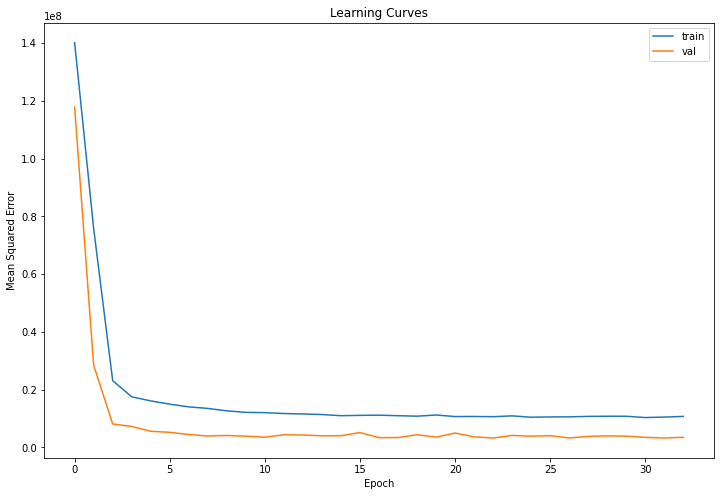

Train RMSE: 1836.610, Train MAPE: 10.609 

Val RMSE: 1804.719, Val MAPE: 10.623 

Test RMSE: 1823.604, Test MAPE: 10.739 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                848       
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dense_5 (Dense)              (None, 32)                544       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0       

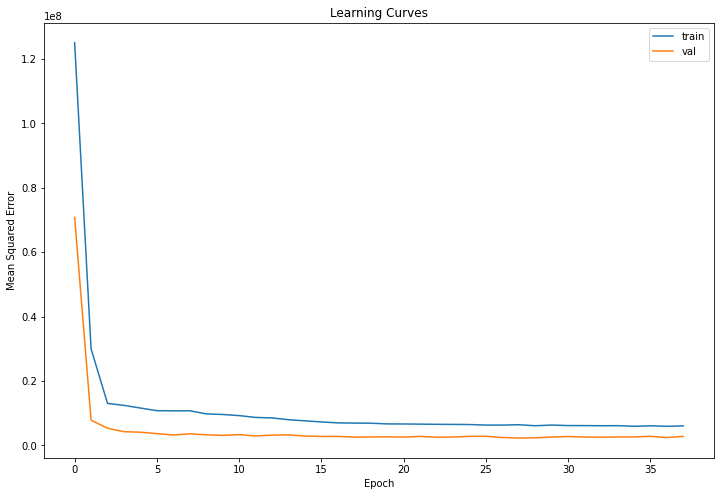

Train RMSE: 1619.172, Train MAPE: 8.767 

Val RMSE: 1635.081, Val MAPE: 8.858 

Test RMSE: 1607.218, Test MAPE: 8.912 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32)                1696      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dense_10 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         


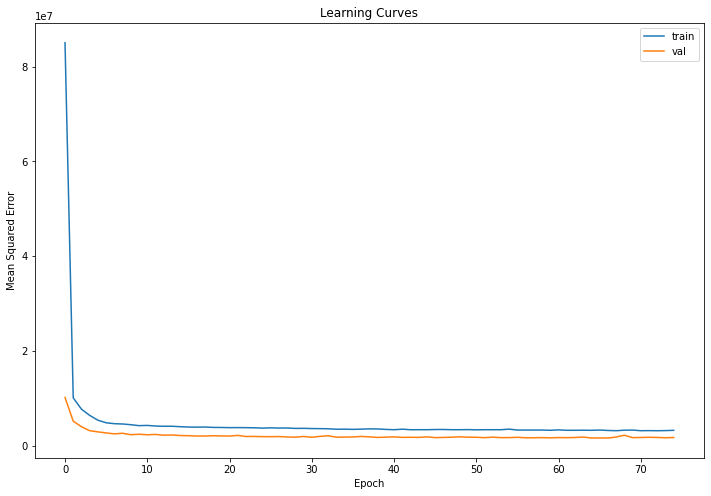

Train RMSE: 1235.133, Train MAPE: 7.575 

Val RMSE: 1284.968, Val MAPE: 7.778 

Test RMSE: 1280.727, Test MAPE: 7.874 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                3392      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64)                256       
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
dense_14 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         


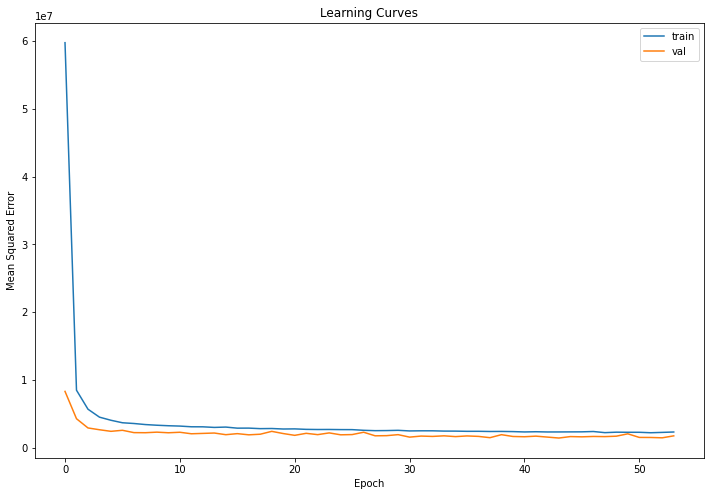

Train RMSE: 1259.215, Train MAPE: 7.060 

Val RMSE: 1343.467, Val MAPE: 7.211 

Test RMSE: 1605.731, Test MAPE: 7.299 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               6784      
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512       
_________________________________________________________________
dense_17 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dense_18 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         


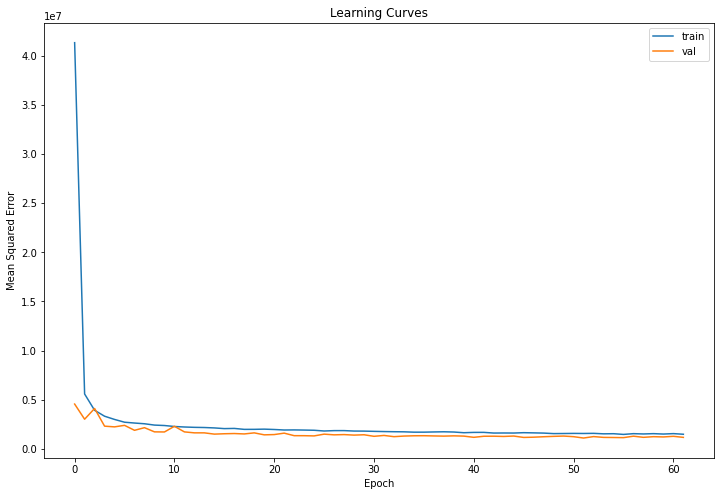

Train RMSE: 974.705, Train MAPE: 5.693 

Val RMSE: 1031.841, Val MAPE: 6.020 

Test RMSE: 1057.165, Test MAPE: 6.052 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 32)                1696      
_________________________________________________________________
batch_normalization_10 (Batc (None, 32)                128       
_________________________________________________________________
dense_21 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_11 (Batc (None, 16)                64        
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                 0         
_

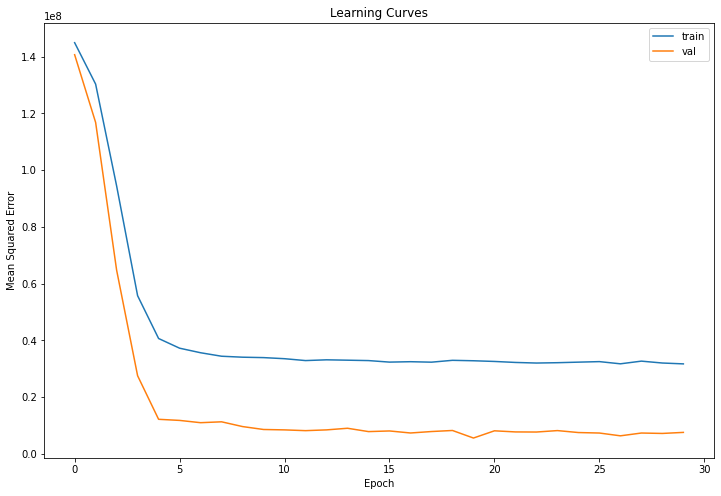

Train RMSE: 2705.681, Train MAPE: 18.122 

Val RMSE: 2679.050, Val MAPE: 18.165 

Test RMSE: 2689.537, Test MAPE: 18.166 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 64)                3392      
_________________________________________________________________
batch_normalization_12 (Batc (None, 64)                256       
_________________________________________________________________
dense_25 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_13 (Batc (None, 32)                128       
_________________________________________________________________
dense_26 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0       

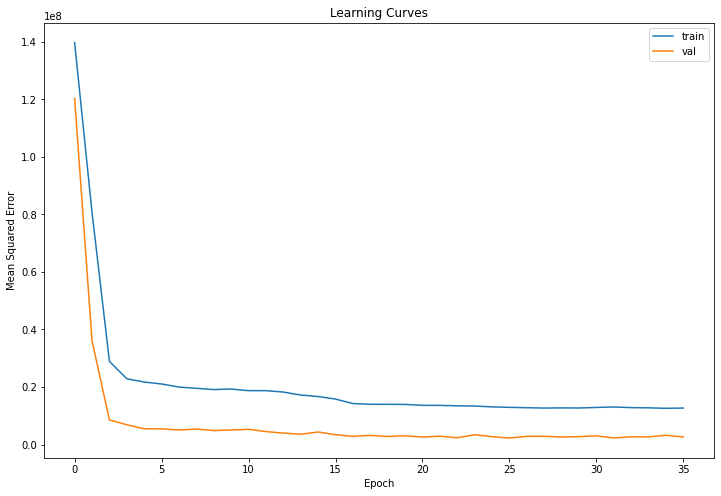

Train RMSE: 1554.423, Train MAPE: 9.075 

Val RMSE: 1564.507, Val MAPE: 9.273 

Test RMSE: 1572.897, Test MAPE: 9.254 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 128)               6784      
_________________________________________________________________
batch_normalization_14 (Batc (None, 128)               512       
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_15 (Batc (None, 64)                256       
_________________________________________________________________
dense_30 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         


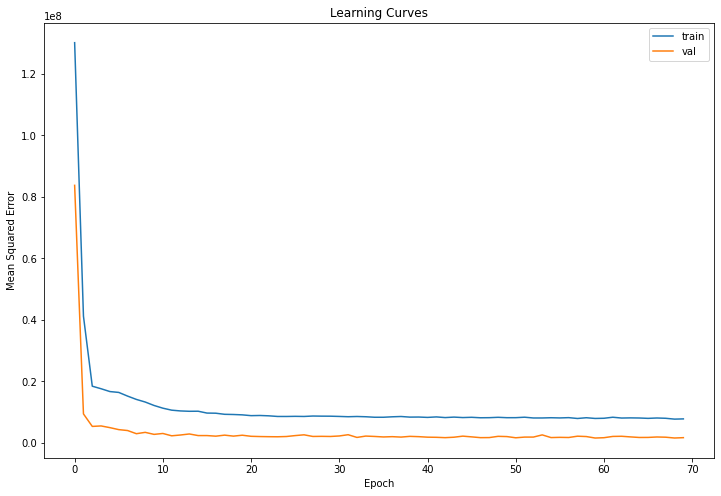

Train RMSE: 1221.836, Train MAPE: 7.512 

Val RMSE: 1246.959, Val MAPE: 7.752 

Test RMSE: 1282.539, Test MAPE: 7.794 

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 256)               13568     
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
dense_33 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_17 (Batc (None, 128)               512       
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         


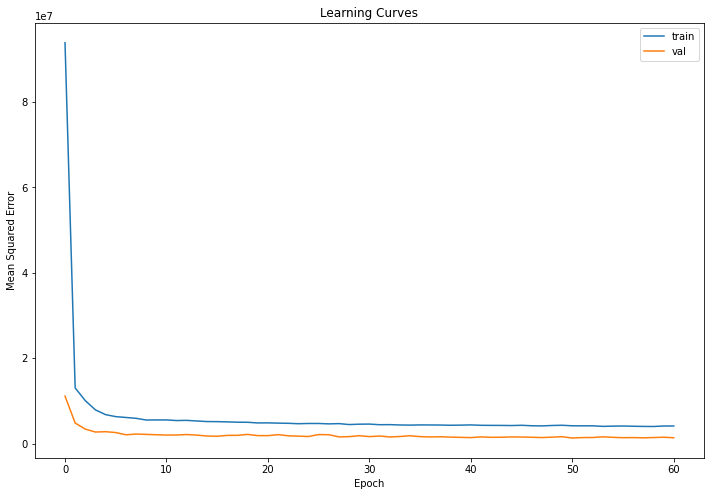

Train RMSE: 1141.700, Train MAPE: 6.810 

Val RMSE: 1173.429, Val MAPE: 7.051 

Test RMSE: 1220.003, Test MAPE: 7.124 

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 512)               27136     
_________________________________________________________________
batch_normalization_18 (Batc (None, 512)               2048      
_________________________________________________________________
dense_37 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_19 (Batc (None, 256)               1024      
_________________________________________________________________
dense_38 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         


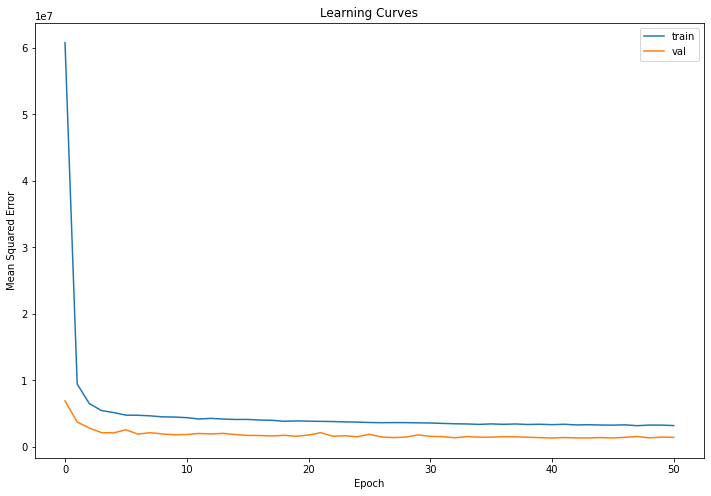

Train RMSE: 1098.354, Train MAPE: 6.539 

Val RMSE: 1114.608, Val MAPE: 6.856 

Test RMSE: 1250.772, Test MAPE: 6.871 

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 8)                 424       
_________________________________________________________________
batch_normalization_20 (Batc (None, 8)                 32        
_________________________________________________________________
dense_41 (Dense)             (None, 16)                144       
_________________________________________________________________
batch_normalization_21 (Batc (None, 16)                64        
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_10 (Dropout)         (None, 8)                 0         

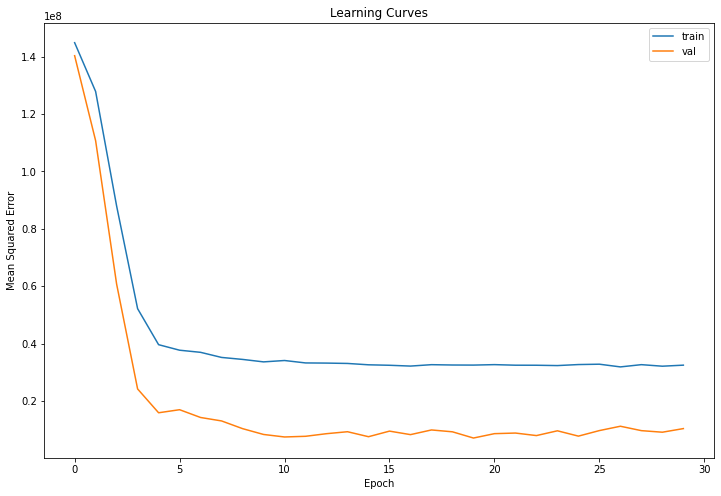

Train RMSE: 3196.438, Train MAPE: 21.000 

Val RMSE: 3155.265, Val MAPE: 21.099 

Test RMSE: 3157.669, Test MAPE: 21.084 

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 16)                848       
_________________________________________________________________
batch_normalization_22 (Batc (None, 16)                64        
_________________________________________________________________
dense_45 (Dense)             (None, 32)                544       
_________________________________________________________________
batch_normalization_23 (Batc (None, 32)                128       
_________________________________________________________________
dense_46 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0      

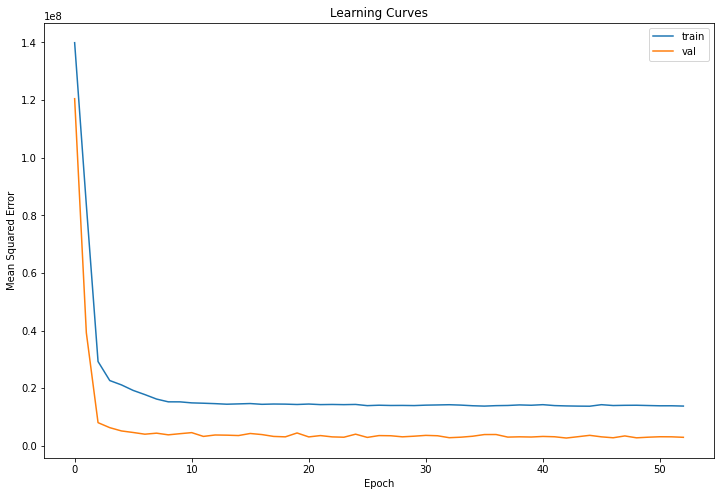

Train RMSE: 1672.477, Train MAPE: 9.531 

Val RMSE: 1675.737, Val MAPE: 9.645 

Test RMSE: 1683.267, Test MAPE: 9.673 

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 32)                1696      
_________________________________________________________________
batch_normalization_24 (Batc (None, 32)                128       
_________________________________________________________________
dense_49 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_25 (Batc (None, 64)                256       
_________________________________________________________________
dense_50 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         

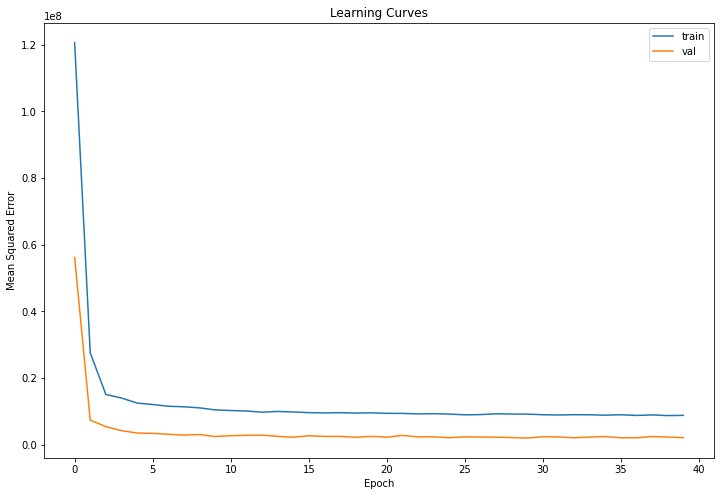

Train RMSE: 1393.503, Train MAPE: 8.308 

Val RMSE: 1396.254, Val MAPE: 8.343 

Test RMSE: 1429.048, Test MAPE: 8.526 

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 64)                3392      
_________________________________________________________________
batch_normalization_26 (Batc (None, 64)                256       
_________________________________________________________________
dense_53 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_27 (Batc (None, 128)               512       
_________________________________________________________________
dense_54 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         

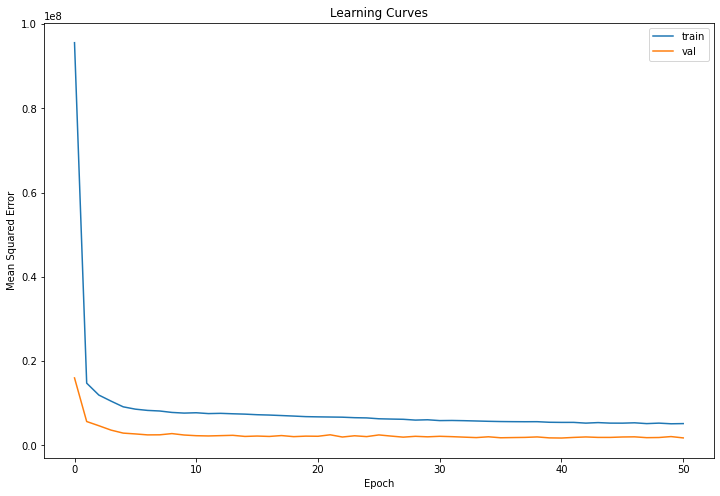

Train RMSE: 1264.300, Train MAPE: 7.706 

Val RMSE: 1295.503, Val MAPE: 7.829 

Test RMSE: 1316.484, Test MAPE: 7.924 

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 128)               6784      
_________________________________________________________________
batch_normalization_28 (Batc (None, 128)               512       
_________________________________________________________________
dense_57 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_29 (Batc (None, 256)               1024      
_________________________________________________________________
dense_58 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         

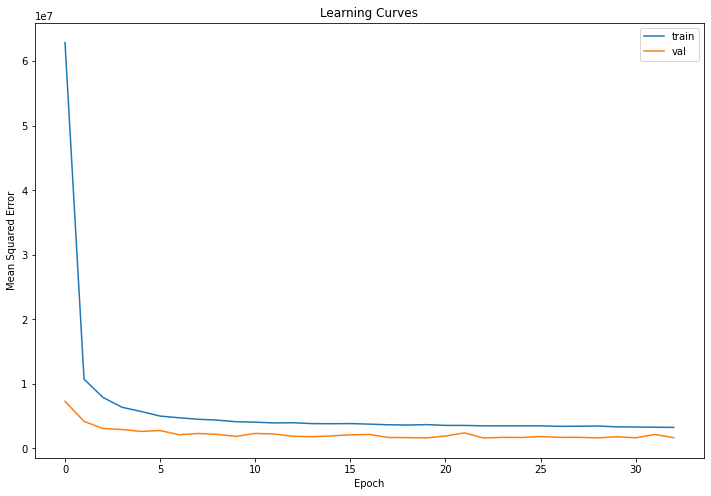

Train RMSE: 1252.948, Train MAPE: 7.015 

Val RMSE: 1283.160, Val MAPE: 7.054 

Test RMSE: 1271.146, Test MAPE: 7.261 

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 256)               13568     
_________________________________________________________________
batch_normalization_30 (Batc (None, 256)               1024      
_________________________________________________________________
dense_61 (Dense)             (None, 512)               131584    
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
dense_62 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         

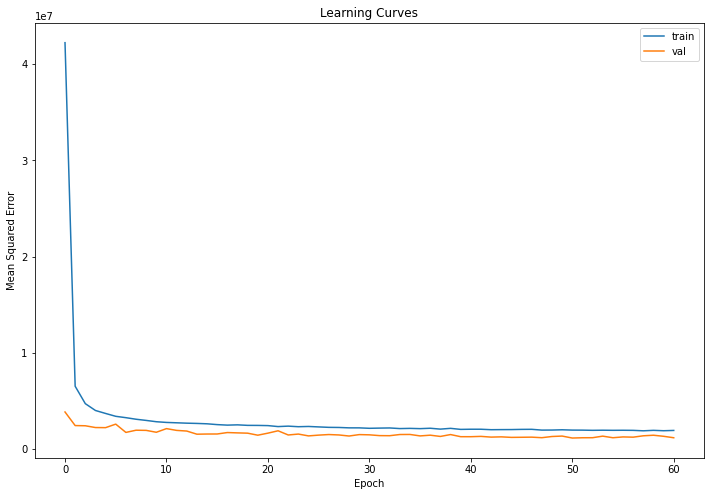

Train RMSE: 997.050, Train MAPE: 5.624 

Val RMSE: 1066.133, Val MAPE: 6.045 

Test RMSE: 1083.959, Test MAPE: 6.103 

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 8)                 424       
_________________________________________________________________
batch_normalization_32 (Batc (None, 8)                 32        
_________________________________________________________________
dense_65 (Dense)             (None, 8)                 72        
_________________________________________________________________
batch_normalization_33 (Batc (None, 8)                 32        
_________________________________________________________________
dense_66 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_16 (Dropout)         (None, 8)                 0         


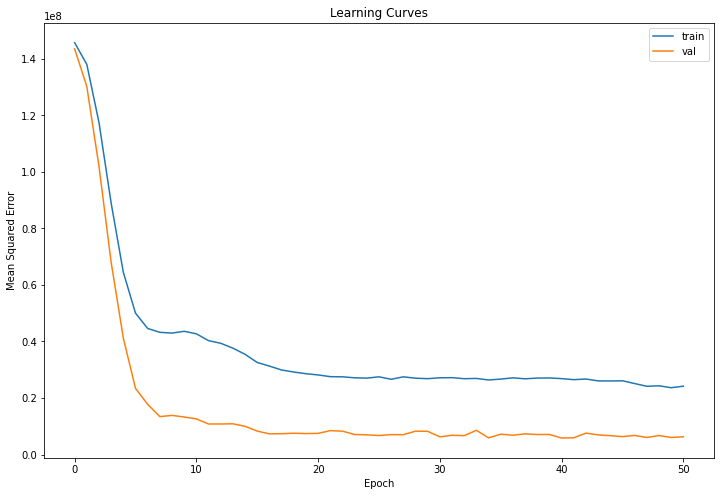

Train RMSE: 2473.579, Train MAPE: 15.473 

Val RMSE: 2435.639, Val MAPE: 15.514 

Test RMSE: 2445.680, Test MAPE: 15.523 

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 16)                848       
_________________________________________________________________
batch_normalization_34 (Batc (None, 16)                64        
_________________________________________________________________
dense_69 (Dense)             (None, 16)                272       
_________________________________________________________________
batch_normalization_35 (Batc (None, 16)                64        
_________________________________________________________________
dense_70 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_17 (Dropout)         (None, 16)                0      

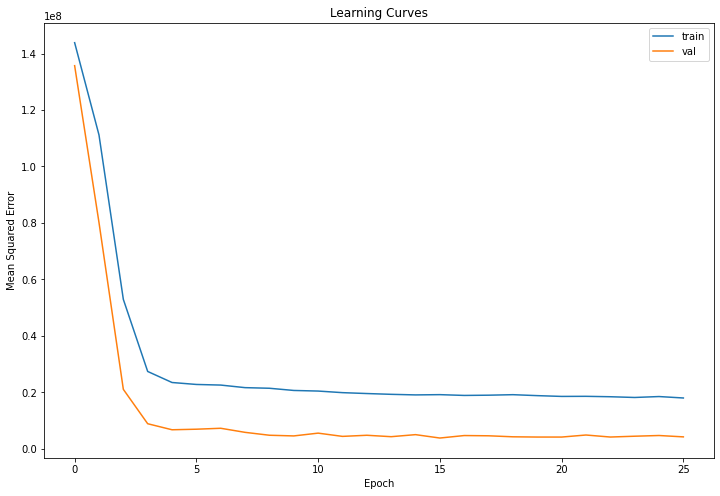

Train RMSE: 2026.082, Train MAPE: 12.677 

Val RMSE: 1995.609, Val MAPE: 12.678 

Test RMSE: 2003.552, Test MAPE: 12.784 

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 32)                1696      
_________________________________________________________________
batch_normalization_36 (Batc (None, 32)                128       
_________________________________________________________________
dense_73 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_37 (Batc (None, 32)                128       
_________________________________________________________________
dense_74 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0      

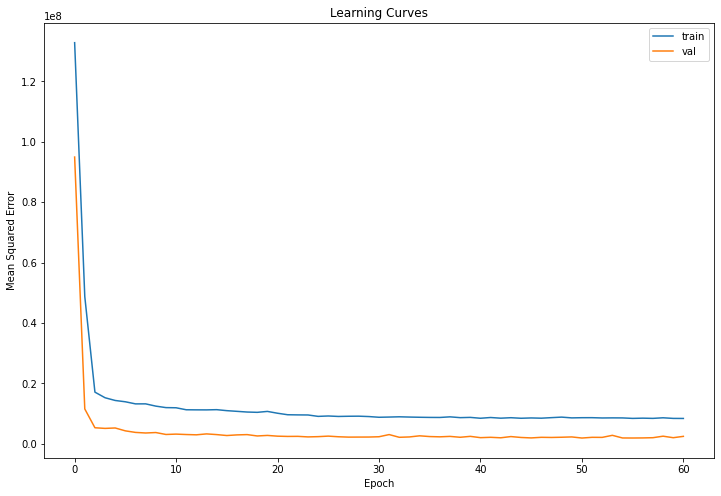

Train RMSE: 1490.118, Train MAPE: 8.909 

Val RMSE: 1511.873, Val MAPE: 9.079 

Test RMSE: 1505.244, Test MAPE: 9.011 

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 64)                3392      
_________________________________________________________________
batch_normalization_38 (Batc (None, 64)                256       
_________________________________________________________________
dense_77 (Dense)             (None, 64)                4160      
_________________________________________________________________
batch_normalization_39 (Batc (None, 64)                256       
_________________________________________________________________
dense_78 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         

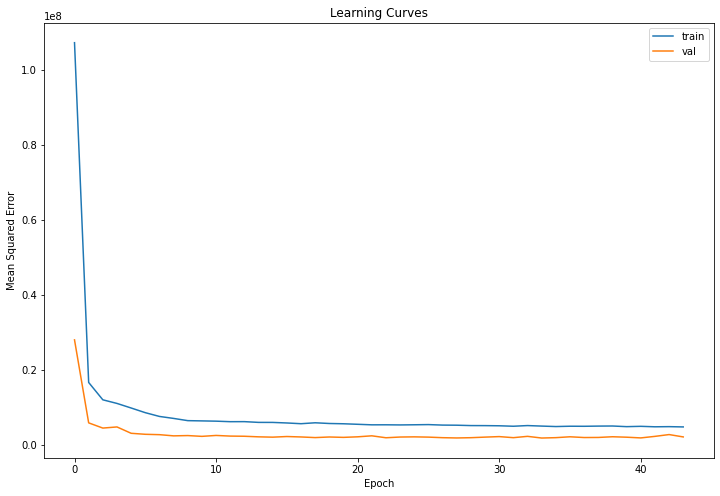

Train RMSE: 1351.155, Train MAPE: 7.335 

Val RMSE: 1385.635, Val MAPE: 7.482 

Test RMSE: 1355.042, Test MAPE: 7.522 

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 128)               6784      
_________________________________________________________________
batch_normalization_40 (Batc (None, 128)               512       
_________________________________________________________________
dense_81 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_41 (Batc (None, 128)               512       
_________________________________________________________________
dense_82 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         

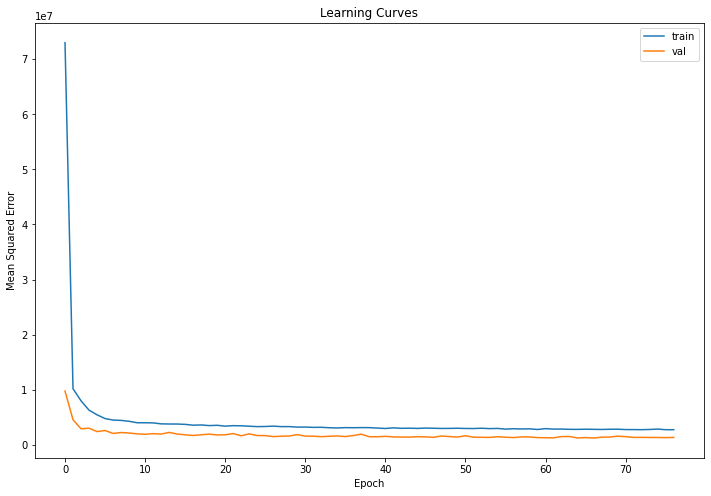

Train RMSE: 1067.705, Train MAPE: 5.980 

Val RMSE: 1090.678, Val MAPE: 6.192 

Test RMSE: 1123.681, Test MAPE: 6.279 

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 256)               13568     
_________________________________________________________________
batch_normalization_42 (Batc (None, 256)               1024      
_________________________________________________________________
dense_85 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_43 (Batc (None, 256)               1024      
_________________________________________________________________
dense_86 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         

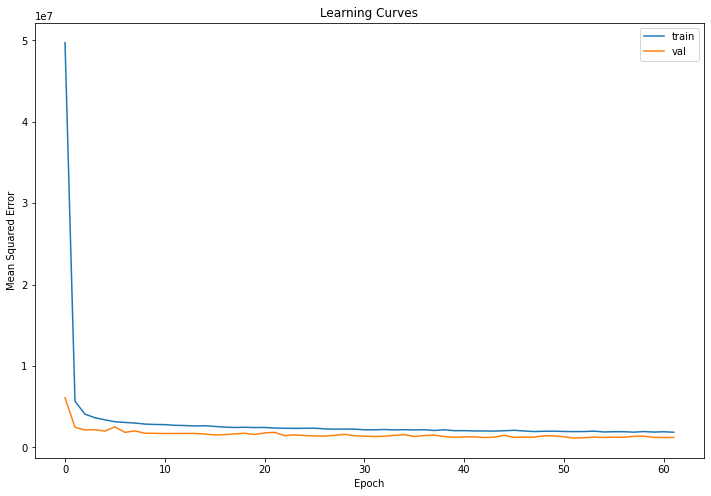

Train RMSE: 1009.992, Train MAPE: 5.970 

Val RMSE: 1077.482, Val MAPE: 6.313 

Test RMSE: 1098.605, Test MAPE: 6.334 

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 512)               27136     
_________________________________________________________________
batch_normalization_44 (Batc (None, 512)               2048      
_________________________________________________________________
dense_89 (Dense)             (None, 512)               262656    
_________________________________________________________________
batch_normalization_45 (Batc (None, 512)               2048      
_________________________________________________________________
dense_90 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)               0         

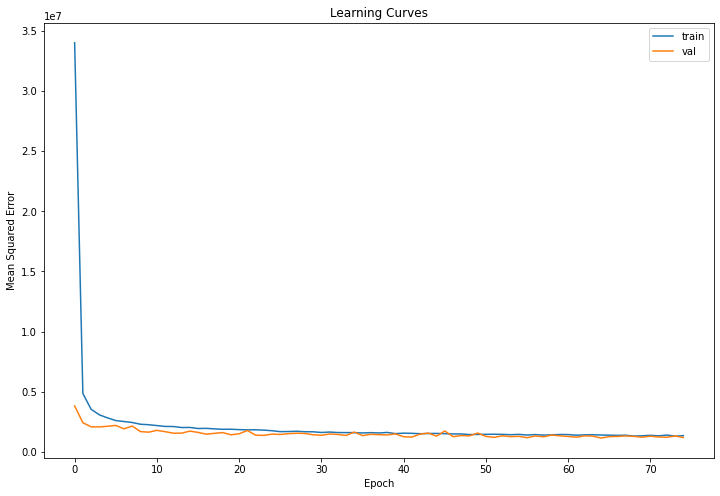

Train RMSE: 961.533, Train MAPE: 5.301 

Val RMSE: 1065.522, Val MAPE: 5.796 

Test RMSE: 1084.535, Test MAPE: 5.840 

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 8)                 424       
_________________________________________________________________
batch_normalization_46 (Batc (None, 8)                 32        
_________________________________________________________________
dense_93 (Dense)             (None, 16)                144       
_________________________________________________________________
dropout_23 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_94 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         


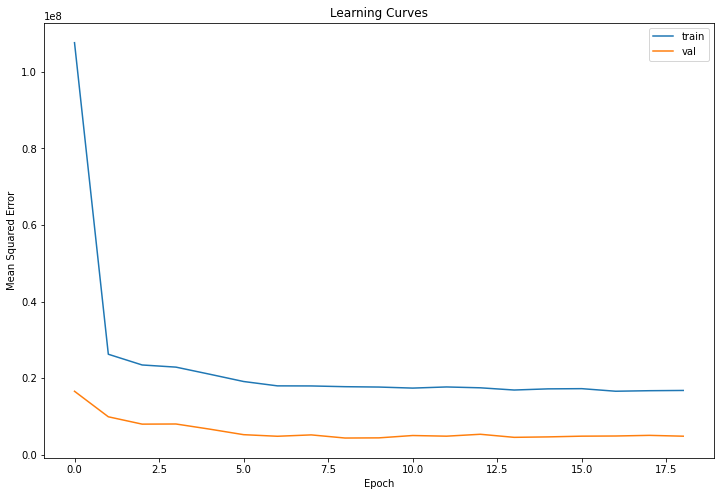

Train RMSE: 2167.850, Train MAPE: 12.067 

Val RMSE: 2111.673, Val MAPE: 11.940 

Test RMSE: 2116.370, Test MAPE: 12.071 

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 16)                848       
_________________________________________________________________
batch_normalization_47 (Batc (None, 16)                64        
_________________________________________________________________
dense_97 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0      

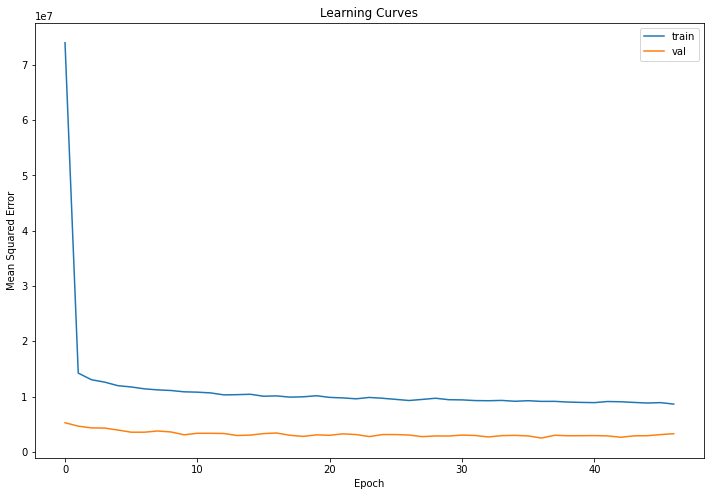

Train RMSE: 1762.517, Train MAPE: 9.944 

Val RMSE: 1745.346, Val MAPE: 9.964 

Test RMSE: 1755.463, Test MAPE: 10.027 

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 32)                1696      
_________________________________________________________________
batch_normalization_48 (Batc (None, 32)                128       
_________________________________________________________________
dense_101 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0        

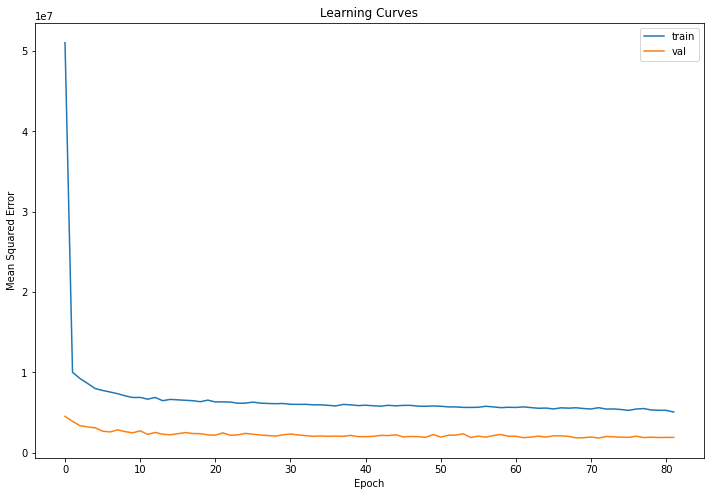

Train RMSE: 1329.233, Train MAPE: 7.745 

Val RMSE: 1364.235, Val MAPE: 7.892 

Test RMSE: 1381.453, Test MAPE: 7.971 

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_104 (Dense)            (None, 64)                3392      
_________________________________________________________________
batch_normalization_49 (Batc (None, 64)                256       
_________________________________________________________________
dense_105 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_29 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_30 (Dropout)         (None, 256)               0         

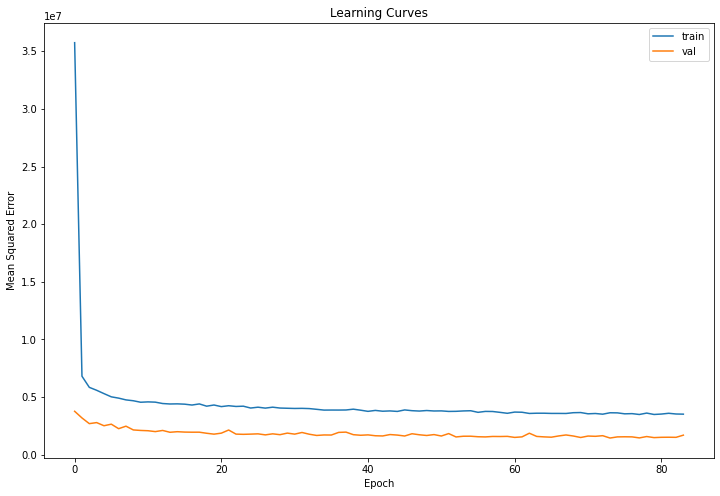

Train RMSE: 1205.787, Train MAPE: 6.846 

Val RMSE: 1223.425, Val MAPE: 7.004 

Test RMSE: 1240.812, Test MAPE: 7.083 

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 128)               6784      
_________________________________________________________________
batch_normalization_50 (Batc (None, 128)               512       
_________________________________________________________________
dense_109 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_31 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_110 (Dense)            (None, 512)               131584    
_________________________________________________________________
dropout_32 (Dropout)         (None, 512)               0         

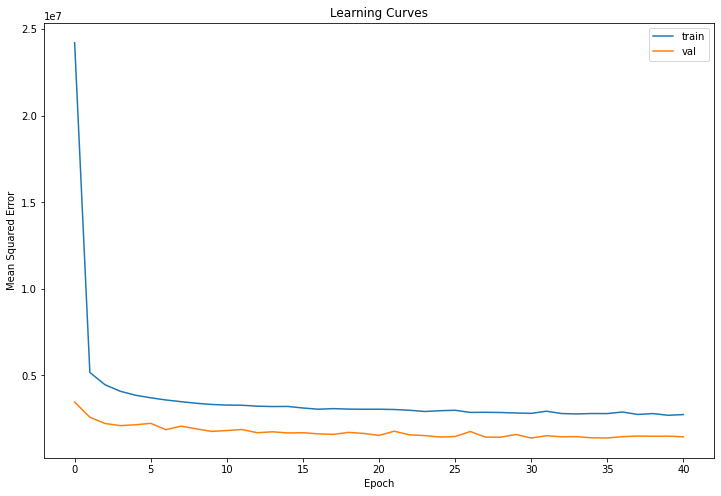

Train RMSE: 1152.748, Train MAPE: 6.919 

Val RMSE: 1184.857, Val MAPE: 7.167 

Test RMSE: 1192.124, Test MAPE: 7.178 

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 32)                1696      
_________________________________________________________________
batch_normalization_51 (Batc (None, 32)                128       
_________________________________________________________________
dense_113 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_33 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_114 (Dense)            (None, 8)                 136       
_________________________________________________________________
dropout_34 (Dropout)         (None, 8)                 0         

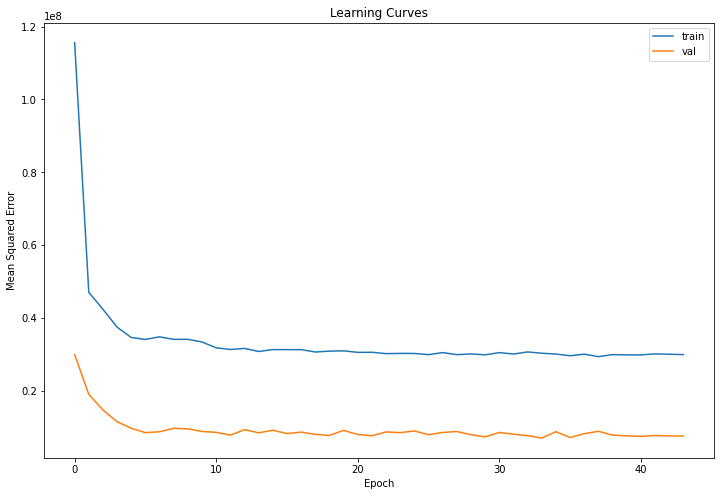

Train RMSE: 2716.851, Train MAPE: 17.893 

Val RMSE: 2682.787, Val MAPE: 17.900 

Test RMSE: 2685.330, Test MAPE: 17.938 

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_116 (Dense)            (None, 64)                3392      
_________________________________________________________________
batch_normalization_52 (Batc (None, 64)                256       
_________________________________________________________________
dense_117 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_35 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_118 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_36 (Dropout)         (None, 16)                0      

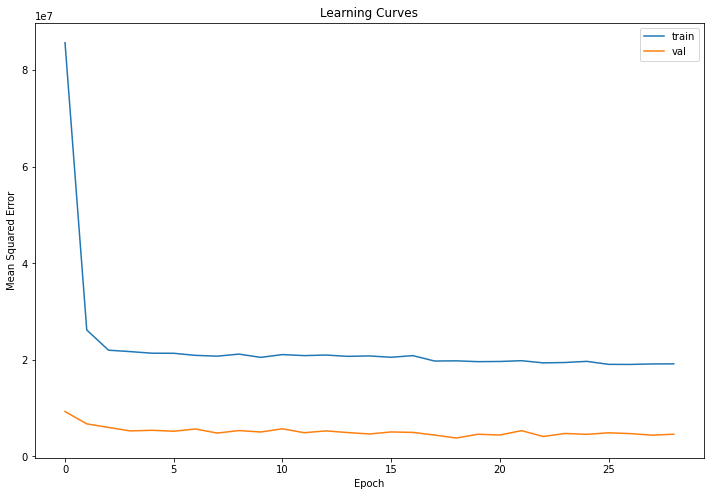

Train RMSE: 2115.042, Train MAPE: 12.372 

Val RMSE: 2087.571, Val MAPE: 12.417 

Test RMSE: 2100.595, Test MAPE: 12.431 

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_120 (Dense)            (None, 128)               6784      
_________________________________________________________________
batch_normalization_53 (Batc (None, 128)               512       
_________________________________________________________________
dense_121 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_37 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_122 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_38 (Dropout)         (None, 32)                0      

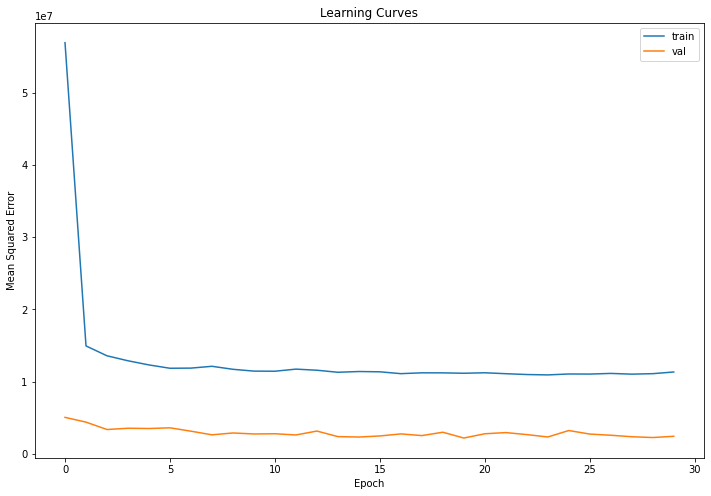

Train RMSE: 1500.353, Train MAPE: 8.688 

Val RMSE: 1495.496, Val MAPE: 8.748 

Test RMSE: 1508.550, Test MAPE: 8.834 

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_124 (Dense)            (None, 256)               13568     
_________________________________________________________________
batch_normalization_54 (Batc (None, 256)               1024      
_________________________________________________________________
dense_125 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_126 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_40 (Dropout)         (None, 64)                0         

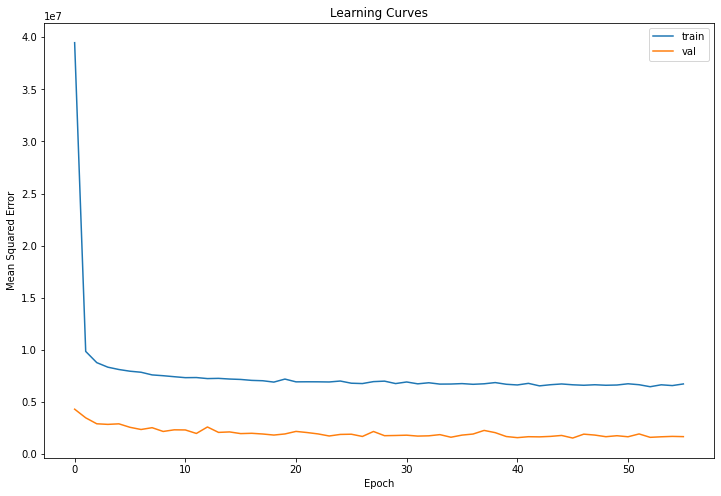

Train RMSE: 1234.712, Train MAPE: 7.375 

Val RMSE: 1277.414, Val MAPE: 7.587 

Test RMSE: 1265.939, Test MAPE: 7.665 

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_128 (Dense)            (None, 512)               27136     
_________________________________________________________________
batch_normalization_55 (Batc (None, 512)               2048      
_________________________________________________________________
dense_129 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_41 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_130 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_42 (Dropout)         (None, 128)               0         

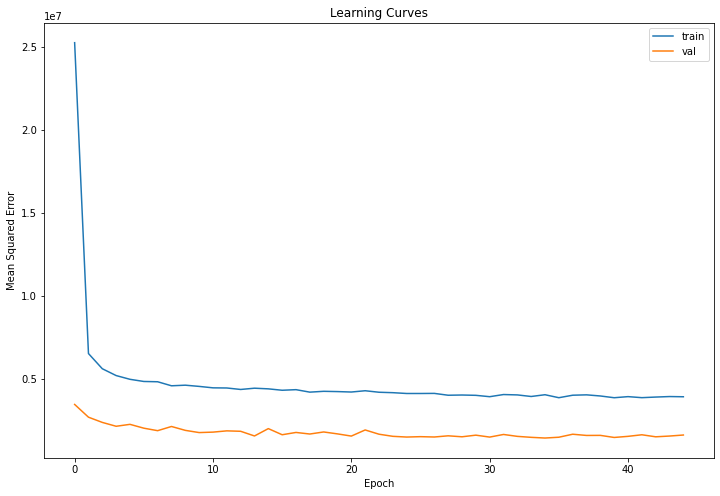

Train RMSE: 1193.856, Train MAPE: 6.755 

Val RMSE: 1230.586, Val MAPE: 7.005 

Test RMSE: 1225.789, Test MAPE: 7.065 

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_132 (Dense)            (None, 8)                 424       
_________________________________________________________________
batch_normalization_56 (Batc (None, 8)                 32        
_________________________________________________________________
dense_133 (Dense)            (None, 16)                144       
_________________________________________________________________
dropout_43 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_134 (Dense)            (None, 8)                 136       
_________________________________________________________________
dropout_44 (Dropout)         (None, 8)                 0         

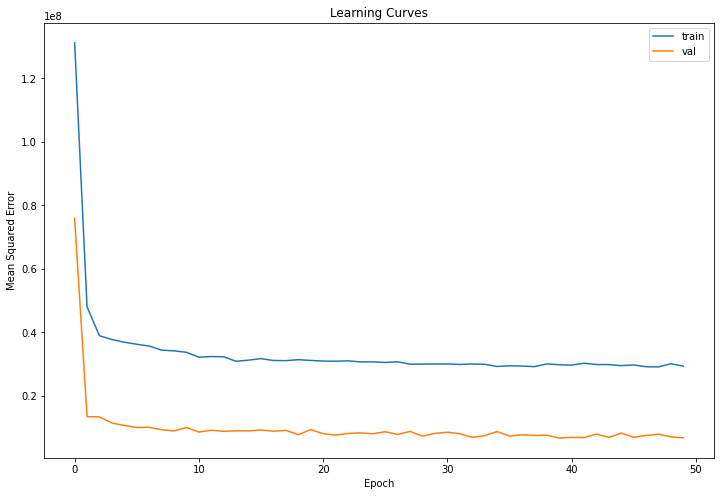

Train RMSE: 2580.086, Train MAPE: 15.939 

Val RMSE: 2563.147, Val MAPE: 15.992 

Test RMSE: 2561.726, Test MAPE: 15.986 

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 16)                848       
_________________________________________________________________
batch_normalization_57 (Batc (None, 16)                64        
_________________________________________________________________
dense_137 (Dense)            (None, 32)                544       
_________________________________________________________________
dropout_45 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_138 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_46 (Dropout)         (None, 16)                0      

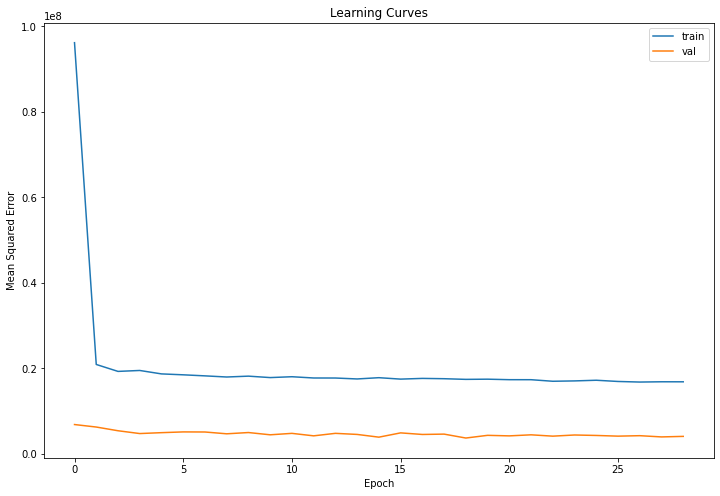

Train RMSE: 1995.321, Train MAPE: 11.242 

Val RMSE: 1964.339, Val MAPE: 11.308 

Test RMSE: 1967.452, Test MAPE: 11.350 

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_140 (Dense)            (None, 32)                1696      
_________________________________________________________________
batch_normalization_58 (Batc (None, 32)                128       
_________________________________________________________________
dense_141 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_47 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_142 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_48 (Dropout)         (None, 32)                0      

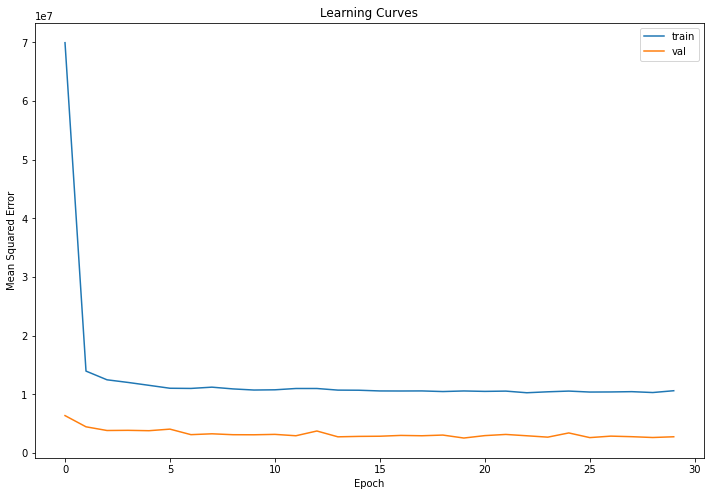

Train RMSE: 1597.933, Train MAPE: 9.078 

Val RMSE: 1586.908, Val MAPE: 9.166 

Test RMSE: 1613.644, Test MAPE: 9.209 

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 64)                3392      
_________________________________________________________________
batch_normalization_59 (Batc (None, 64)                256       
_________________________________________________________________
dense_145 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_49 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_146 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_50 (Dropout)         (None, 64)                0         

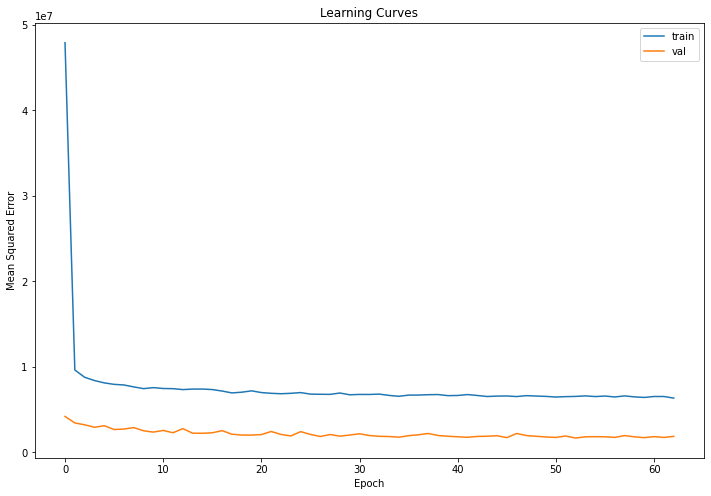

Train RMSE: 1325.735, Train MAPE: 7.744 

Val RMSE: 1336.468, Val MAPE: 7.901 

Test RMSE: 1338.325, Test MAPE: 7.961 

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (None, 128)               6784      
_________________________________________________________________
batch_normalization_60 (Batc (None, 128)               512       
_________________________________________________________________
dense_149 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_51 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_150 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_52 (Dropout)         (None, 128)               0         

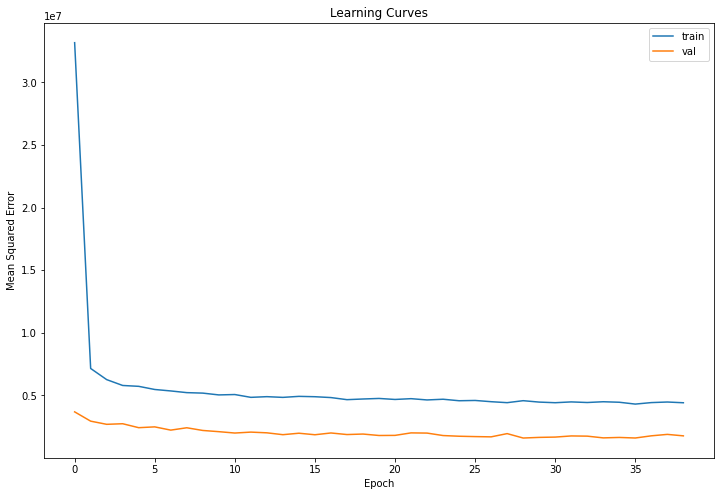

Train RMSE: 1252.693, Train MAPE: 7.346 

Val RMSE: 1280.528, Val MAPE: 7.429 

Test RMSE: 1277.723, Test MAPE: 7.567 

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_152 (Dense)            (None, 256)               13568     
_________________________________________________________________
batch_normalization_61 (Batc (None, 256)               1024      
_________________________________________________________________
dense_153 (Dense)            (None, 512)               131584    
_________________________________________________________________
dropout_53 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_154 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_54 (Dropout)         (None, 256)               0         

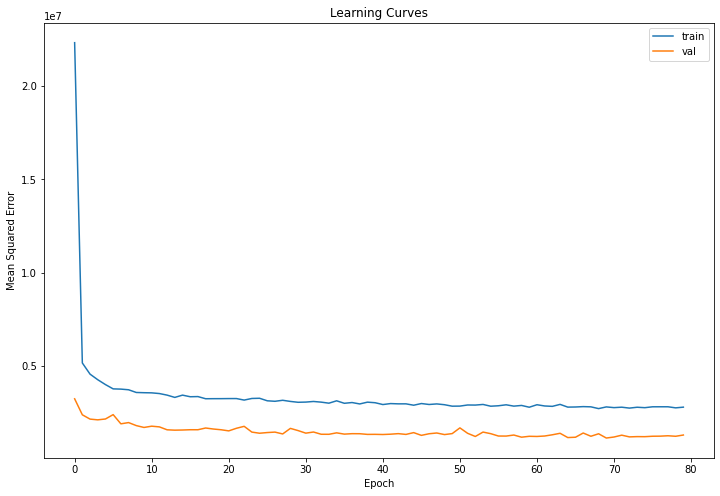

Train RMSE: 1064.150, Train MAPE: 6.294 

Val RMSE: 1104.576, Val MAPE: 6.647 

Test RMSE: 1123.136, Test MAPE: 6.632 

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 8)                 424       
_________________________________________________________________
batch_normalization_62 (Batc (None, 8)                 32        
_________________________________________________________________
dense_157 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_55 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_158 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_56 (Dropout)         (None, 8)                 0         

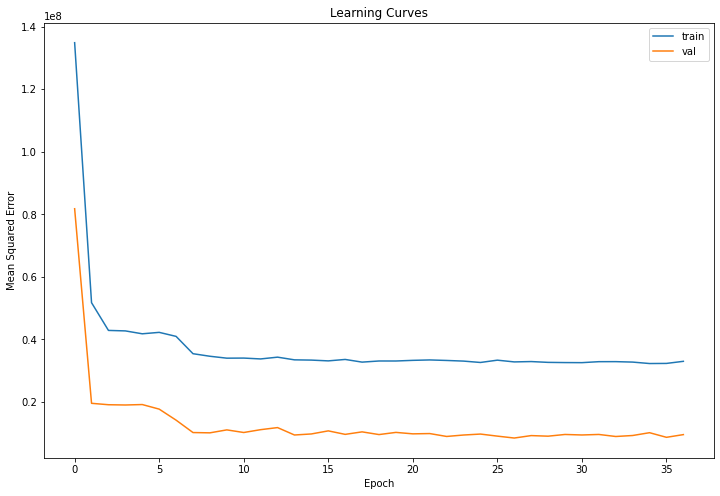

Train RMSE: 3075.302, Train MAPE: 20.459 

Val RMSE: 3026.240, Val MAPE: 20.355 

Test RMSE: 3048.125, Test MAPE: 20.479 

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_160 (Dense)            (None, 16)                848       
_________________________________________________________________
batch_normalization_63 (Batc (None, 16)                64        
_________________________________________________________________
dense_161 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_57 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_162 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_58 (Dropout)         (None, 16)                0      

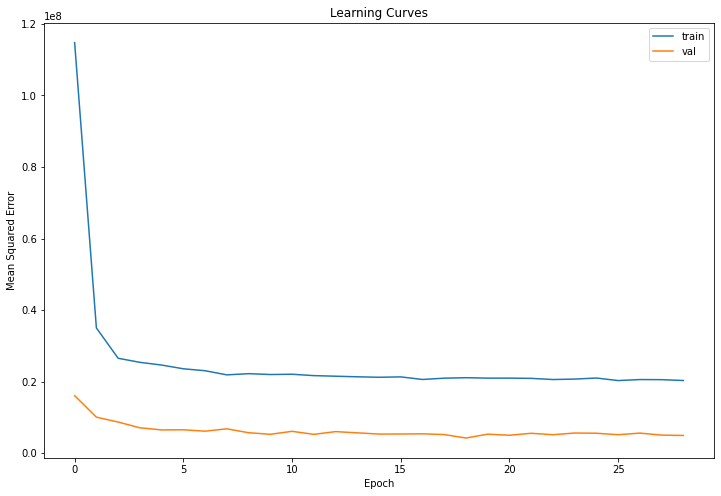

Train RMSE: 2194.706, Train MAPE: 13.217 

Val RMSE: 2166.153, Val MAPE: 13.265 

Test RMSE: 2176.618, Test MAPE: 13.328 

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_164 (Dense)            (None, 32)                1696      
_________________________________________________________________
batch_normalization_64 (Batc (None, 32)                128       
_________________________________________________________________
dense_165 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_59 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_166 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_60 (Dropout)         (None, 32)                0      

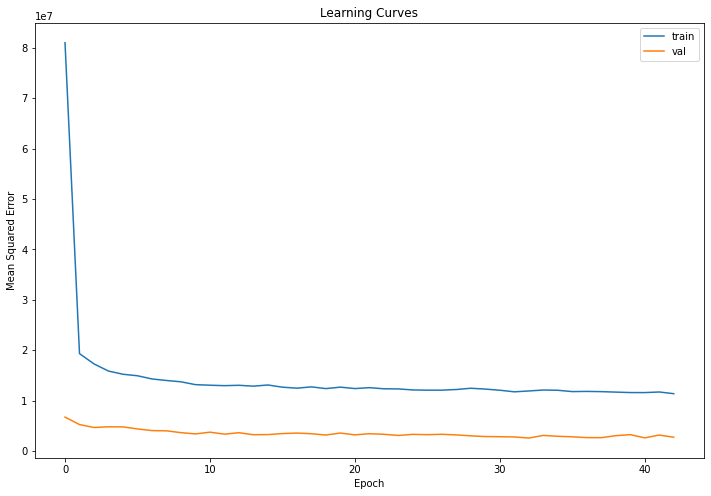

Train RMSE: 1605.020, Train MAPE: 8.995 

Val RMSE: 1595.795, Val MAPE: 9.055 

Test RMSE: 1602.712, Test MAPE: 9.126 

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_168 (Dense)            (None, 64)                3392      
_________________________________________________________________
batch_normalization_65 (Batc (None, 64)                256       
_________________________________________________________________
dense_169 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_61 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_170 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_62 (Dropout)         (None, 64)                0         

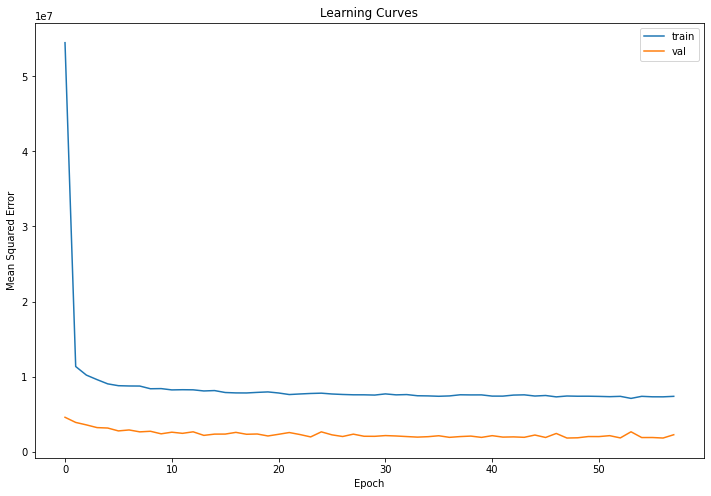

Train RMSE: 1439.502, Train MAPE: 8.579 

Val RMSE: 1451.351, Val MAPE: 8.722 

Test RMSE: 1439.603, Test MAPE: 8.724 

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_172 (Dense)            (None, 128)               6784      
_________________________________________________________________
batch_normalization_66 (Batc (None, 128)               512       
_________________________________________________________________
dense_173 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_63 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_174 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_64 (Dropout)         (None, 128)               0         

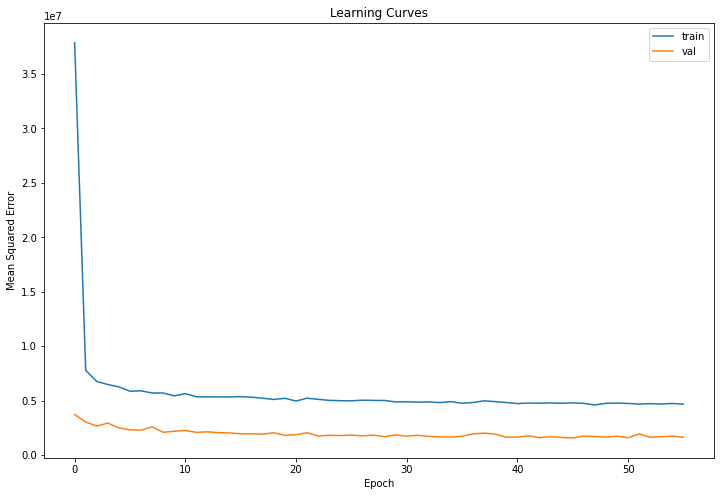

Train RMSE: 1199.902, Train MAPE: 7.019 

Val RMSE: 1212.986, Val MAPE: 7.190 

Test RMSE: 1239.701, Test MAPE: 7.272 

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_176 (Dense)            (None, 256)               13568     
_________________________________________________________________
batch_normalization_67 (Batc (None, 256)               1024      
_________________________________________________________________
dense_177 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_65 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_178 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_66 (Dropout)         (None, 256)               0         

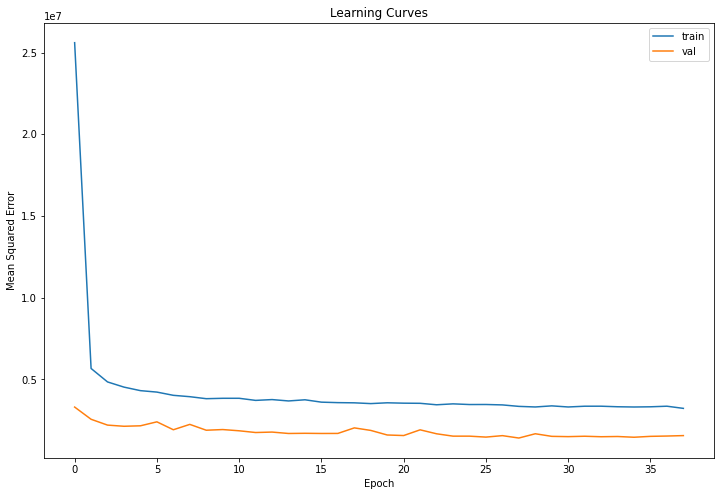

Train RMSE: 1172.093, Train MAPE: 7.053 

Val RMSE: 1209.327, Val MAPE: 7.342 

Test RMSE: 1228.414, Test MAPE: 7.363 

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_180 (Dense)            (None, 512)               27136     
_________________________________________________________________
batch_normalization_68 (Batc (None, 512)               2048      
_________________________________________________________________
dense_181 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_67 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_182 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_68 (Dropout)         (None, 512)               0         

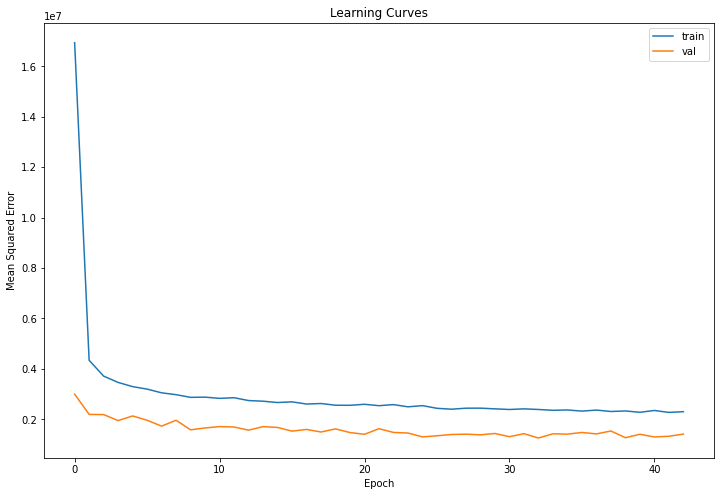

Train RMSE: 1121.755, Train MAPE: 7.262 

Val RMSE: 1175.415, Val MAPE: 7.566 

Test RMSE: 1182.119, Test MAPE: 7.551 

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_184 (Dense)            (None, 8)                 424       
_________________________________________________________________
dropout_69 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_185 (Dense)            (None, 16)                144       
_________________________________________________________________
batch_normalization_69 (Batc (None, 16)                64        
_________________________________________________________________
dense_186 (Dense)            (None, 32)                544       
_________________________________________________________________
dropout_70 (Dropout)         (None, 32)                0         

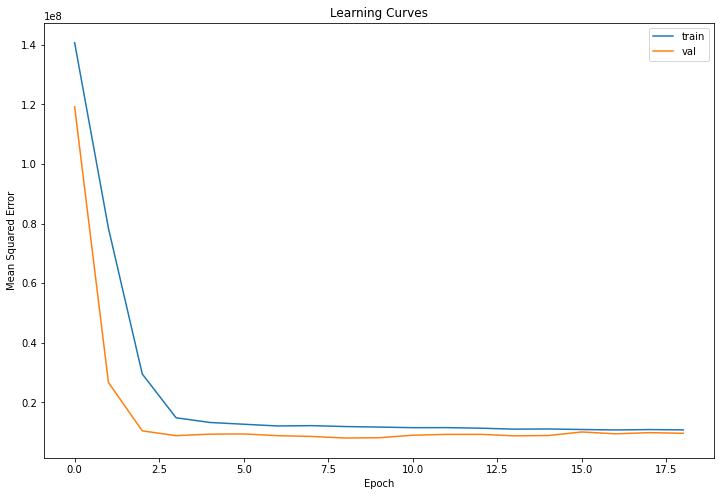

Train RMSE: 3078.877, Train MAPE: 16.267 

Val RMSE: 3044.300, Val MAPE: 16.265 

Test RMSE: 3044.584, Test MAPE: 16.378 

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_188 (Dense)            (None, 16)                848       
_________________________________________________________________
dropout_71 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_189 (Dense)            (None, 32)                544       
_________________________________________________________________
batch_normalization_70 (Batc (None, 32)                128       
_________________________________________________________________
dense_190 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_72 (Dropout)         (None, 64)                0      

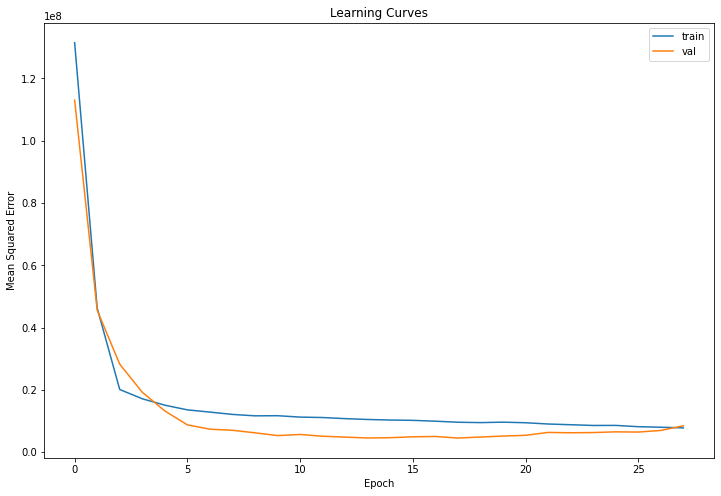

Train RMSE: 2886.002, Train MAPE: 26.603 

Val RMSE: 2868.399, Val MAPE: 26.707 

Test RMSE: 2864.207, Test MAPE: 26.583 

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_192 (Dense)            (None, 32)                1696      
_________________________________________________________________
dropout_73 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_193 (Dense)            (None, 64)                2112      
_________________________________________________________________
batch_normalization_71 (Batc (None, 64)                256       
_________________________________________________________________
dense_194 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_74 (Dropout)         (None, 128)               0      

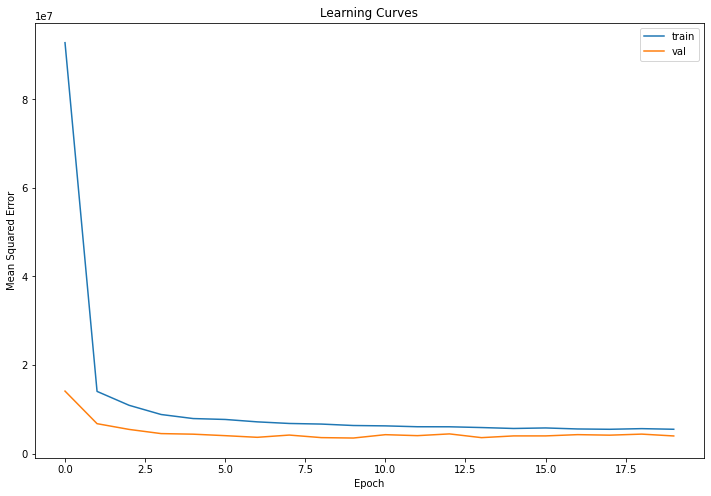

Train RMSE: 1938.591, Train MAPE: 10.654 

Val RMSE: 1948.430, Val MAPE: 10.729 

Test RMSE: 1935.990, Test MAPE: 10.754 

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_196 (Dense)            (None, 64)                3392      
_________________________________________________________________
dropout_75 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_197 (Dense)            (None, 128)               8320      
_________________________________________________________________
batch_normalization_72 (Batc (None, 128)               512       
_________________________________________________________________
dense_198 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_76 (Dropout)         (None, 256)               0      

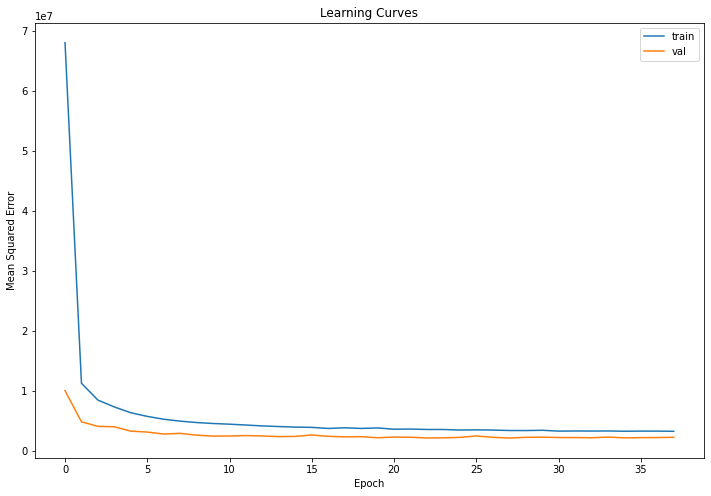

Train RMSE: 1399.425, Train MAPE: 9.107 

Val RMSE: 1423.155, Val MAPE: 9.280 

Test RMSE: 1447.365, Test MAPE: 9.315 

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_200 (Dense)            (None, 128)               6784      
_________________________________________________________________
dropout_77 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_201 (Dense)            (None, 256)               33024     
_________________________________________________________________
batch_normalization_73 (Batc (None, 256)               1024      
_________________________________________________________________
dense_202 (Dense)            (None, 512)               131584    
_________________________________________________________________
dropout_78 (Dropout)         (None, 512)               0         

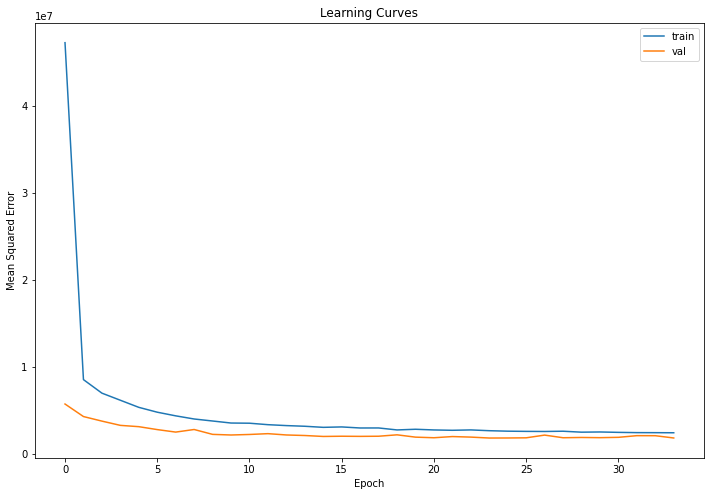

Train RMSE: 1256.530, Train MAPE: 8.273 

Val RMSE: 1274.404, Val MAPE: 8.362 

Test RMSE: 1288.309, Test MAPE: 8.506 

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_204 (Dense)            (None, 32)                1696      
_________________________________________________________________
dropout_79 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_205 (Dense)            (None, 16)                528       
_________________________________________________________________
batch_normalization_74 (Batc (None, 16)                64        
_________________________________________________________________
dense_206 (Dense)            (None, 8)                 136       
_________________________________________________________________
dropout_80 (Dropout)         (None, 8)                 0         

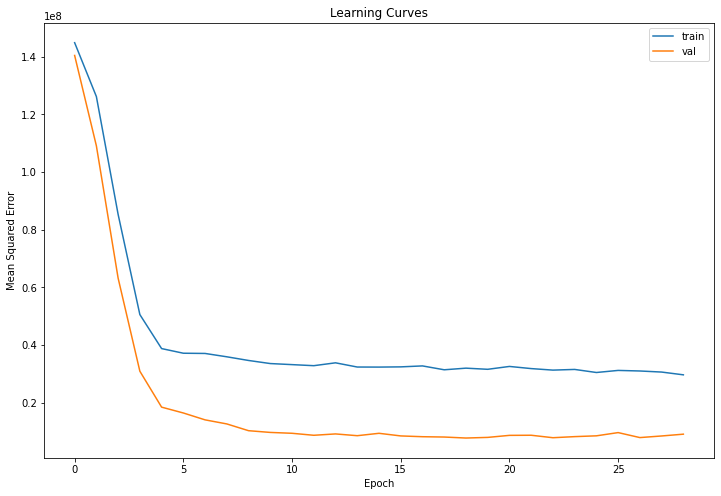

Train RMSE: 2961.864, Train MAPE: 16.914 

Val RMSE: 2934.797, Val MAPE: 16.885 

Test RMSE: 2940.850, Test MAPE: 17.020 

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_208 (Dense)            (None, 64)                3392      
_________________________________________________________________
dropout_81 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_209 (Dense)            (None, 32)                2080      
_________________________________________________________________
batch_normalization_75 (Batc (None, 32)                128       
_________________________________________________________________
dense_210 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_82 (Dropout)         (None, 16)                0      

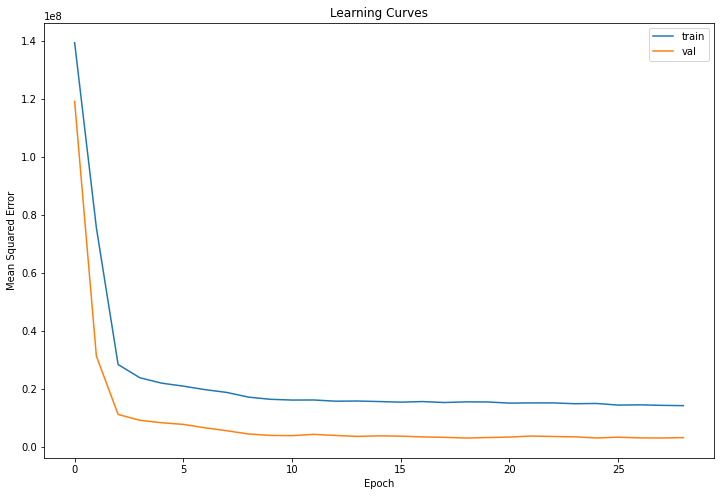

Train RMSE: 1705.875, Train MAPE: 9.812 

Val RMSE: 1710.592, Val MAPE: 9.903 

Test RMSE: 1715.457, Test MAPE: 9.983 

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_212 (Dense)            (None, 128)               6784      
_________________________________________________________________
dropout_83 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_213 (Dense)            (None, 64)                8256      
_________________________________________________________________
batch_normalization_76 (Batc (None, 64)                256       
_________________________________________________________________
dense_214 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_84 (Dropout)         (None, 32)                0         

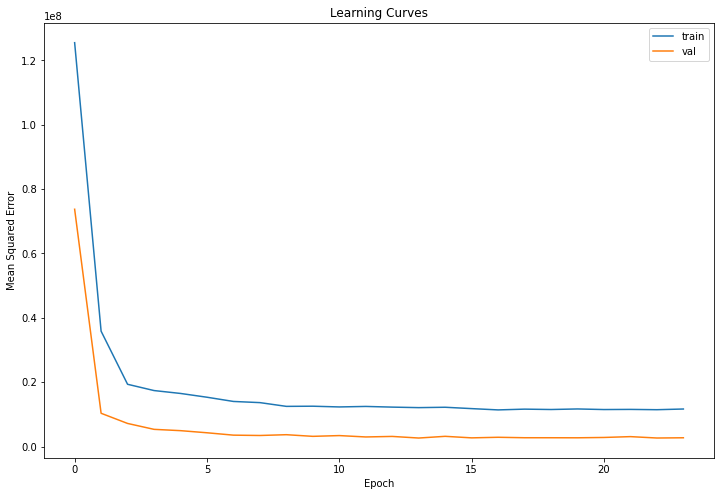

Train RMSE: 1588.544, Train MAPE: 9.067 

Val RMSE: 1580.865, Val MAPE: 9.074 

Test RMSE: 1601.636, Test MAPE: 9.257 

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_216 (Dense)            (None, 256)               13568     
_________________________________________________________________
dropout_85 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_217 (Dense)            (None, 128)               32896     
_________________________________________________________________
batch_normalization_77 (Batc (None, 128)               512       
_________________________________________________________________
dense_218 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_86 (Dropout)         (None, 64)                0         

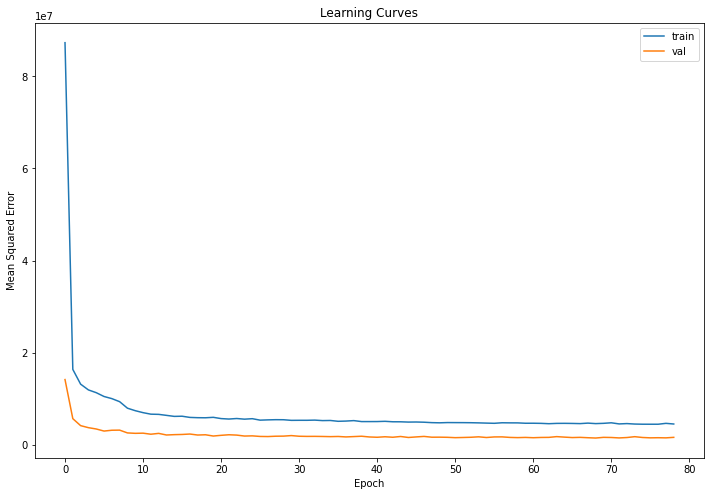

Train RMSE: 1196.429, Train MAPE: 6.654 

Val RMSE: 1213.574, Val MAPE: 6.833 

Test RMSE: 1226.794, Test MAPE: 6.953 

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_220 (Dense)            (None, 512)               27136     
_________________________________________________________________
dropout_87 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_221 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_78 (Batc (None, 256)               1024      
_________________________________________________________________
dense_222 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_88 (Dropout)         (None, 128)               0         

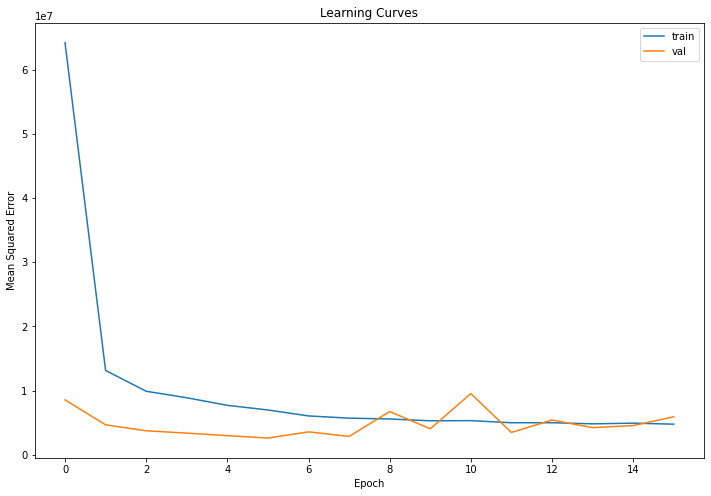

Train RMSE: 2670.116, Train MAPE: 7.852 

Val RMSE: 2543.522, Val MAPE: 7.967 

Test RMSE: 2599.966, Test MAPE: 8.066 

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_224 (Dense)            (None, 8)                 424       
_________________________________________________________________
dropout_89 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_225 (Dense)            (None, 16)                144       
_________________________________________________________________
batch_normalization_79 (Batc (None, 16)                64        
_________________________________________________________________
dense_226 (Dense)            (None, 8)                 136       
_________________________________________________________________
dropout_90 (Dropout)         (None, 8)                 0         

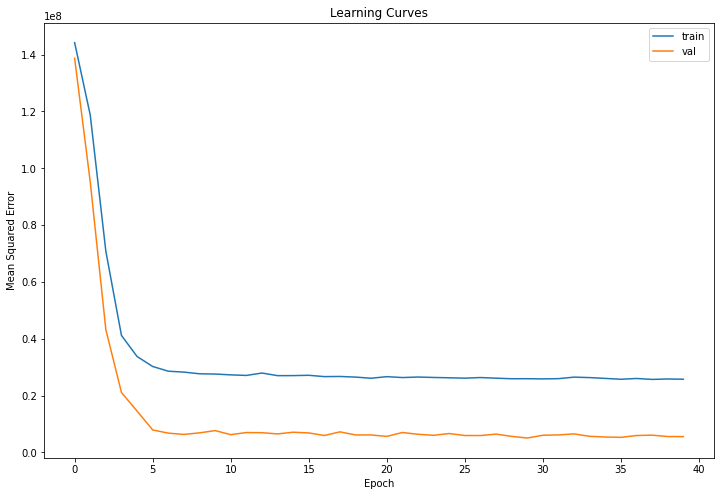

Train RMSE: 2327.806, Train MAPE: 13.290 

Val RMSE: 2279.026, Val MAPE: 13.252 

Test RMSE: 2289.892, Test MAPE: 13.240 

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_228 (Dense)            (None, 16)                848       
_________________________________________________________________
dropout_91 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_229 (Dense)            (None, 32)                544       
_________________________________________________________________
batch_normalization_80 (Batc (None, 32)                128       
_________________________________________________________________
dense_230 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_92 (Dropout)         (None, 16)                0      

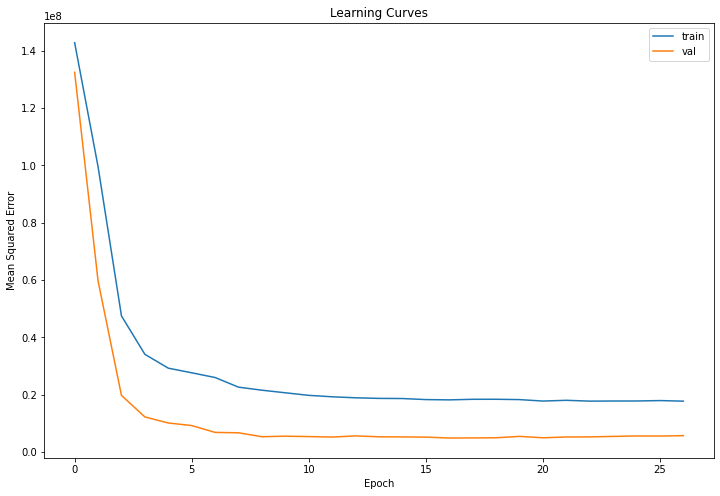

Train RMSE: 2373.721, Train MAPE: 18.625 

Val RMSE: 2352.135, Val MAPE: 18.786 

Test RMSE: 2348.682, Test MAPE: 18.596 

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_232 (Dense)            (None, 32)                1696      
_________________________________________________________________
dropout_93 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_233 (Dense)            (None, 64)                2112      
_________________________________________________________________
batch_normalization_81 (Batc (None, 64)                256       
_________________________________________________________________
dense_234 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_94 (Dropout)         (None, 32)                0      

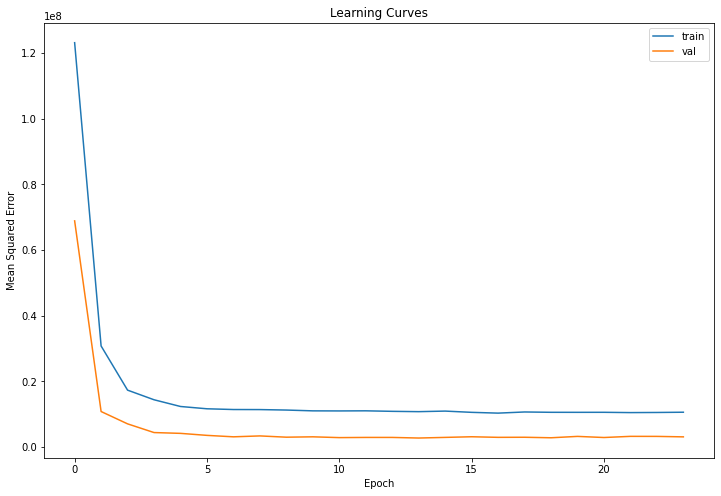

Train RMSE: 1709.349, Train MAPE: 9.785 

Val RMSE: 1701.610, Val MAPE: 9.829 

Test RMSE: 1692.084, Test MAPE: 9.881 

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_236 (Dense)            (None, 64)                3392      
_________________________________________________________________
dropout_95 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_237 (Dense)            (None, 128)               8320      
_________________________________________________________________
batch_normalization_82 (Batc (None, 128)               512       
_________________________________________________________________
dense_238 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_96 (Dropout)         (None, 64)                0         

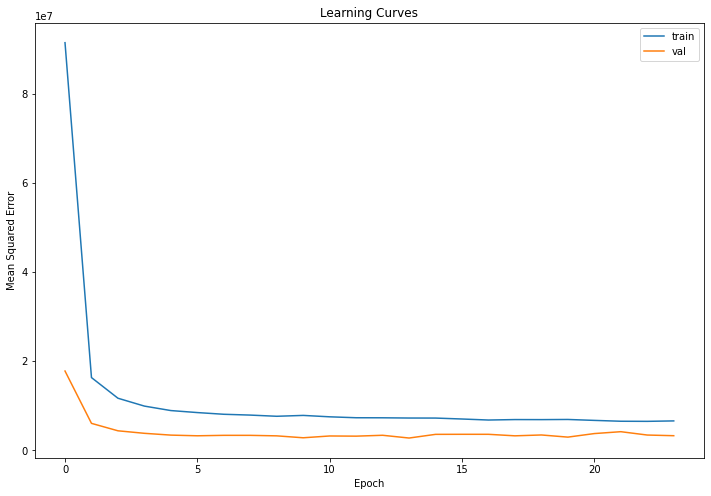

Train RMSE: 1742.078, Train MAPE: 10.031 

Val RMSE: 1735.631, Val MAPE: 10.035 

Test RMSE: 1745.237, Test MAPE: 10.204 

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_240 (Dense)            (None, 128)               6784      
_________________________________________________________________
dropout_97 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_241 (Dense)            (None, 256)               33024     
_________________________________________________________________
batch_normalization_83 (Batc (None, 256)               1024      
_________________________________________________________________
dense_242 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_98 (Dropout)         (None, 128)               0      

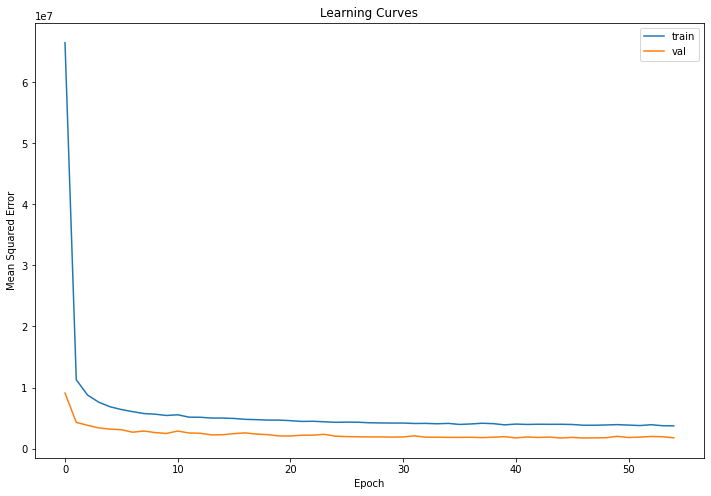

Train RMSE: 1222.143, Train MAPE: 7.128 

Val RMSE: 1230.548, Val MAPE: 7.253 

Test RMSE: 1260.068, Test MAPE: 7.379 

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_244 (Dense)            (None, 256)               13568     
_________________________________________________________________
dropout_99 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_245 (Dense)            (None, 512)               131584    
_________________________________________________________________
batch_normalization_84 (Batc (None, 512)               2048      
_________________________________________________________________
dense_246 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_100 (Dropout)        (None, 256)               0         

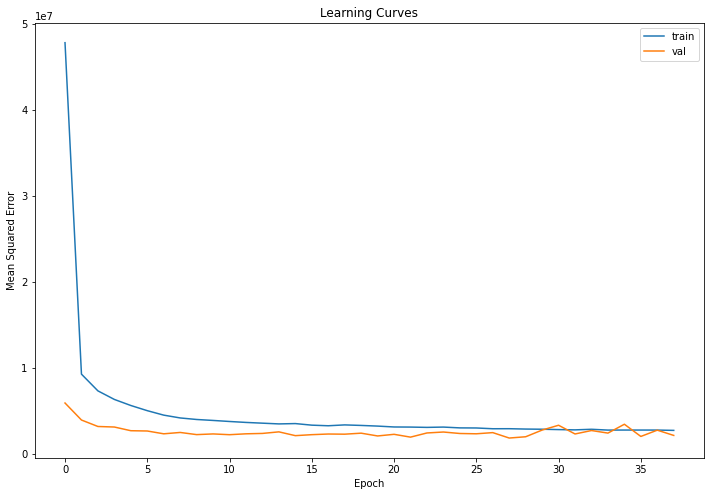

Train RMSE: 1367.699, Train MAPE: 7.080 

Val RMSE: 1345.269, Val MAPE: 7.193 

Test RMSE: 1423.247, Test MAPE: 7.392 

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_248 (Dense)            (None, 8)                 424       
_________________________________________________________________
dropout_101 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_249 (Dense)            (None, 8)                 72        
_________________________________________________________________
batch_normalization_85 (Batc (None, 8)                 32        
_________________________________________________________________
dense_250 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_102 (Dropout)        (None, 8)                 0         

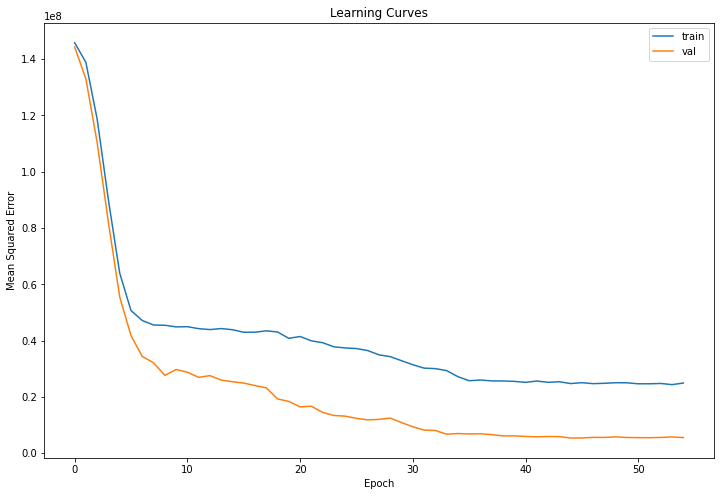

Train RMSE: 2335.196, Train MAPE: 17.080 

Val RMSE: 2312.207, Val MAPE: 17.159 

Test RMSE: 2302.646, Test MAPE: 17.056 

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_252 (Dense)            (None, 16)                848       
_________________________________________________________________
dropout_103 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_253 (Dense)            (None, 16)                272       
_________________________________________________________________
batch_normalization_86 (Batc (None, 16)                64        
_________________________________________________________________
dense_254 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_104 (Dropout)        (None, 16)                0      

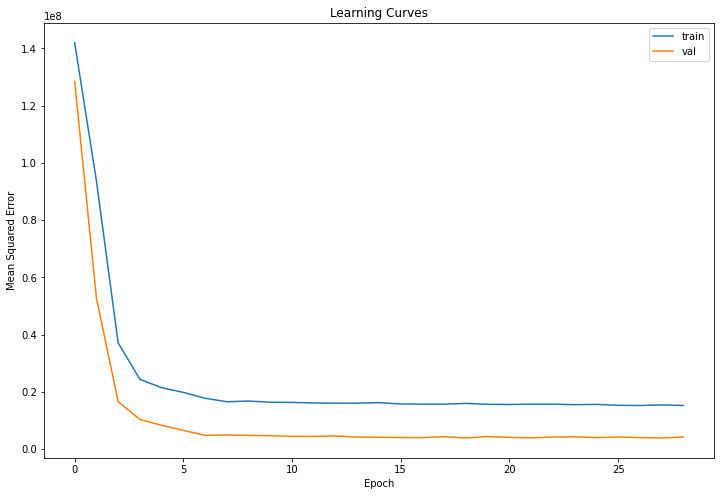

Train RMSE: 2018.288, Train MAPE: 13.944 

Val RMSE: 1993.654, Val MAPE: 13.968 

Test RMSE: 2001.118, Test MAPE: 13.920 

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_256 (Dense)            (None, 32)                1696      
_________________________________________________________________
dropout_105 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_257 (Dense)            (None, 32)                1056      
_________________________________________________________________
batch_normalization_87 (Batc (None, 32)                128       
_________________________________________________________________
dense_258 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_106 (Dropout)        (None, 32)                0      

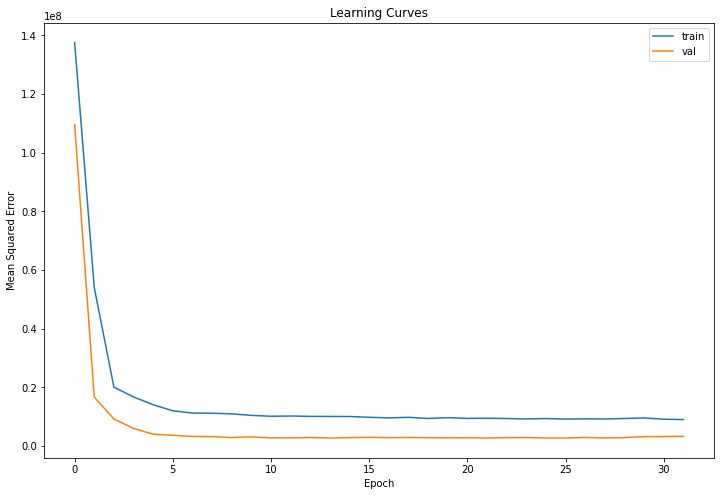

Train RMSE: 1776.169, Train MAPE: 10.977 

Val RMSE: 1774.085, Val MAPE: 11.081 

Test RMSE: 1800.893, Test MAPE: 11.151 

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_260 (Dense)            (None, 64)                3392      
_________________________________________________________________
dropout_107 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_261 (Dense)            (None, 64)                4160      
_________________________________________________________________
batch_normalization_88 (Batc (None, 64)                256       
_________________________________________________________________
dense_262 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_108 (Dropout)        (None, 64)                0      

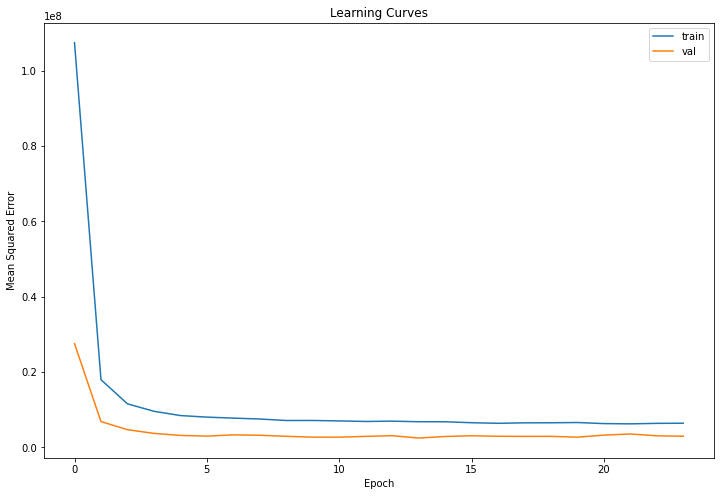

Train RMSE: 1662.555, Train MAPE: 9.864 

Val RMSE: 1671.088, Val MAPE: 9.917 

Test RMSE: 1676.993, Test MAPE: 9.999 

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_264 (Dense)            (None, 128)               6784      
_________________________________________________________________
dropout_109 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_265 (Dense)            (None, 128)               16512     
_________________________________________________________________
batch_normalization_89 (Batc (None, 128)               512       
_________________________________________________________________
dense_266 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_110 (Dropout)        (None, 128)               0         

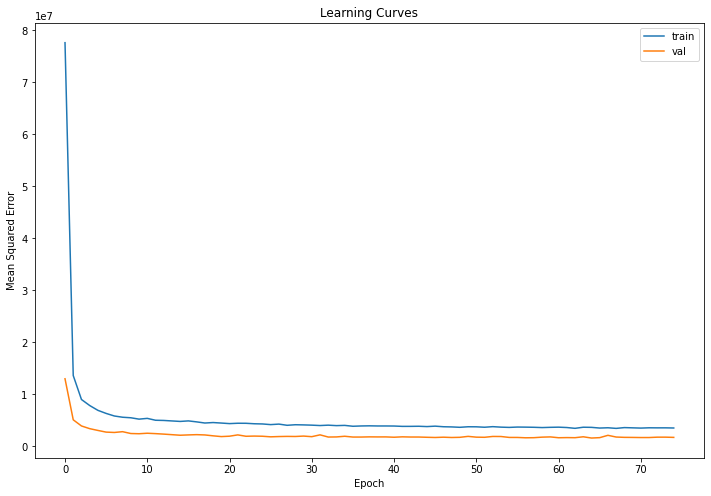

Train RMSE: 1213.899, Train MAPE: 6.851 

Val RMSE: 1225.418, Val MAPE: 7.011 

Test RMSE: 1261.537, Test MAPE: 7.104 

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_268 (Dense)            (None, 256)               13568     
_________________________________________________________________
dropout_111 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_269 (Dense)            (None, 256)               65792     
_________________________________________________________________
batch_normalization_90 (Batc (None, 256)               1024      
_________________________________________________________________
dense_270 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_112 (Dropout)        (None, 256)               0         

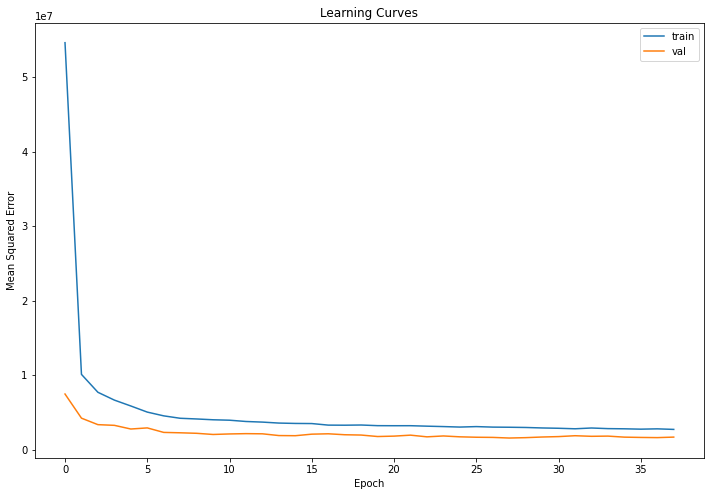

Train RMSE: 1237.258, Train MAPE: 6.812 

Val RMSE: 1251.271, Val MAPE: 6.967 

Test RMSE: 1270.560, Test MAPE: 7.112 

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_272 (Dense)            (None, 512)               27136     
_________________________________________________________________
dropout_113 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_273 (Dense)            (None, 512)               262656    
_________________________________________________________________
batch_normalization_91 (Batc (None, 512)               2048      
_________________________________________________________________
dense_274 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_114 (Dropout)        (None, 512)               0         

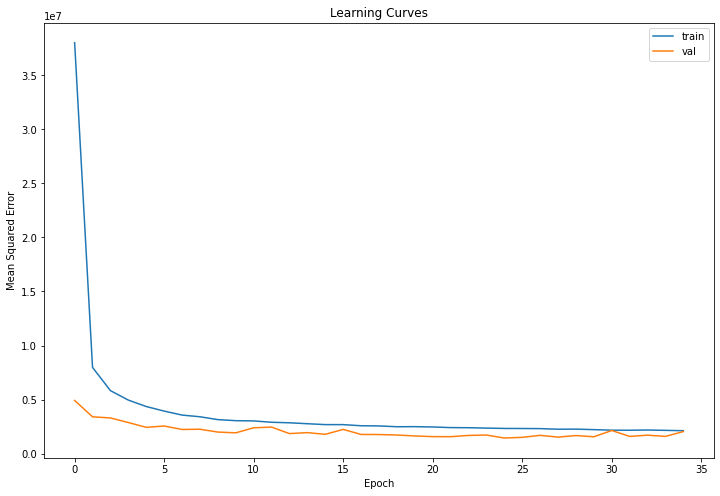

Train RMSE: 1413.165, Train MAPE: 6.607 

Val RMSE: 1414.053, Val MAPE: 6.775 

Test RMSE: 1474.924, Test MAPE: 6.951 

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_276 (Dense)            (None, 8)                 424       
_________________________________________________________________
dropout_115 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_277 (Dense)            (None, 16)                144       
_________________________________________________________________
dropout_116 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_278 (Dense)            (None, 32)                544       
_________________________________________________________________
dropout_117 (Dropout)        (None, 32)                0         

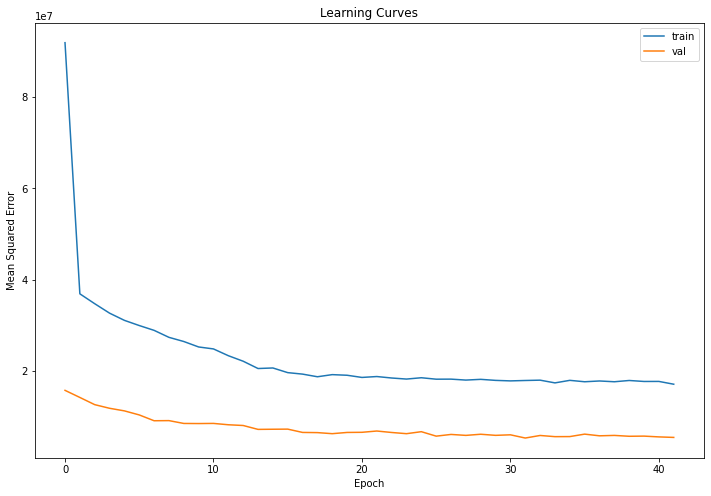

Train RMSE: 2299.883, Train MAPE: 13.167 

Val RMSE: 2242.116, Val MAPE: 13.080 

Test RMSE: 2256.091, Test MAPE: 13.220 

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_280 (Dense)            (None, 16)                848       
_________________________________________________________________
dropout_118 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_281 (Dense)            (None, 32)                544       
_________________________________________________________________
dropout_119 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_282 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_120 (Dropout)        (None, 64)                0      

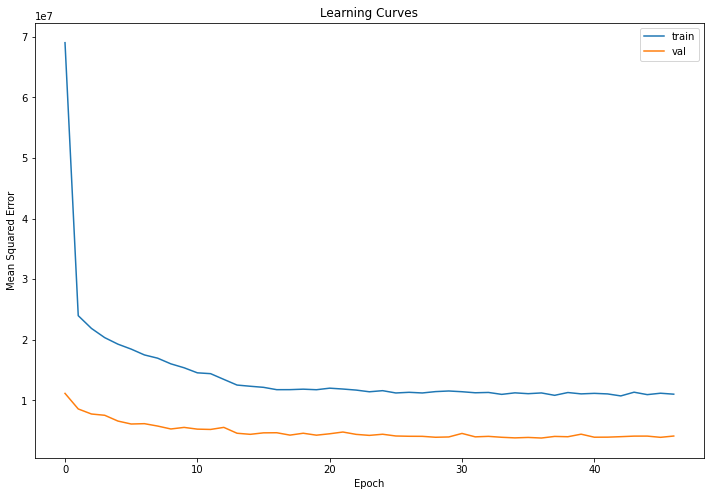

Train RMSE: 2011.053, Train MAPE: 11.840 

Val RMSE: 1967.729, Val MAPE: 11.798 

Test RMSE: 1974.792, Test MAPE: 11.896 

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_284 (Dense)            (None, 32)                1696      
_________________________________________________________________
dropout_121 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_285 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_122 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_286 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_123 (Dropout)        (None, 128)               0      

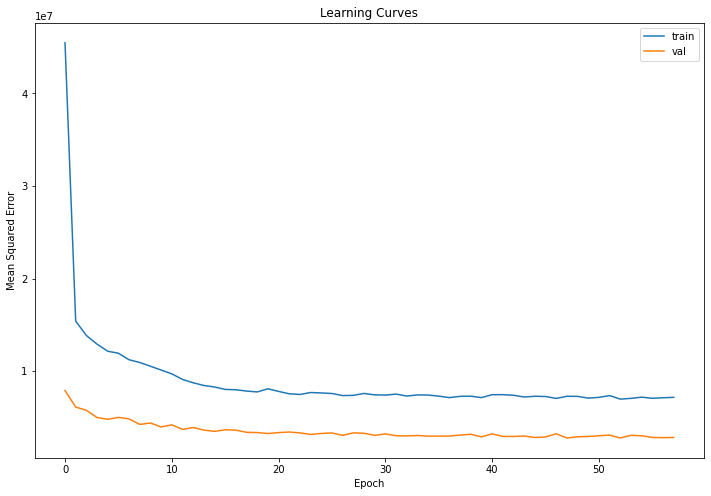

Train RMSE: 1663.935, Train MAPE: 10.315 

Val RMSE: 1646.371, Val MAPE: 10.303 

Test RMSE: 1646.985, Test MAPE: 10.411 

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_288 (Dense)            (None, 64)                3392      
_________________________________________________________________
dropout_124 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_289 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_125 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_290 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_126 (Dropout)        (None, 256)               0      

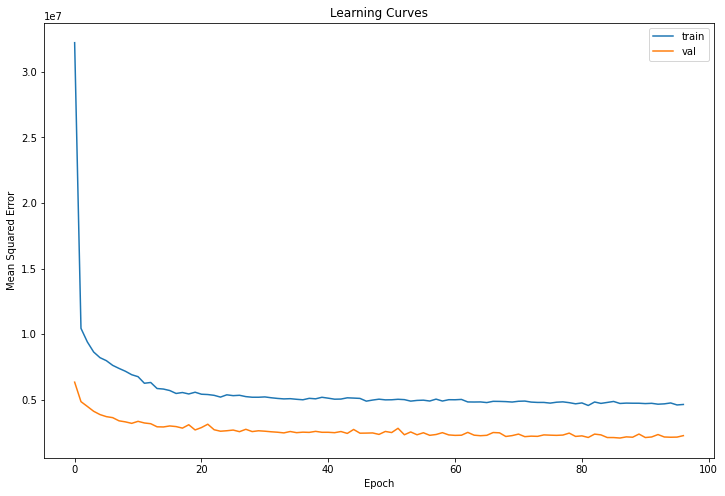

Train RMSE: 1475.870, Train MAPE: 9.067 

Val RMSE: 1485.785, Val MAPE: 9.114 

Test RMSE: 1482.251, Test MAPE: 9.242 

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_292 (Dense)            (None, 128)               6784      
_________________________________________________________________
dropout_127 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_293 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_128 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_294 (Dense)            (None, 512)               131584    
_________________________________________________________________
dropout_129 (Dropout)        (None, 512)               0         

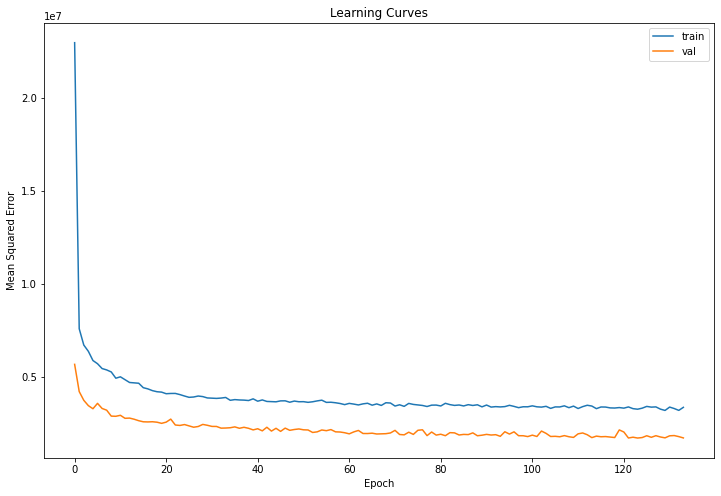

Train RMSE: 1274.133, Train MAPE: 8.082 

Val RMSE: 1330.348, Val MAPE: 8.193 

Test RMSE: 1333.511, Test MAPE: 8.250 

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_296 (Dense)            (None, 32)                1696      
_________________________________________________________________
dropout_130 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_297 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_131 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_298 (Dense)            (None, 8)                 136       
_________________________________________________________________
dropout_132 (Dropout)        (None, 8)                 0         

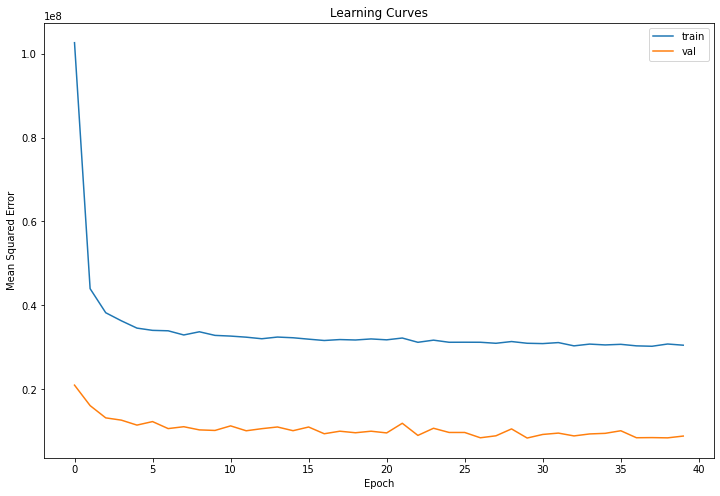

Train RMSE: 2943.905, Train MAPE: 18.045 

Val RMSE: 2885.344, Val MAPE: 17.969 

Test RMSE: 2904.815, Test MAPE: 18.123 

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_300 (Dense)            (None, 64)                3392      
_________________________________________________________________
dropout_133 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_301 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_134 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_302 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_135 (Dropout)        (None, 16)                0      

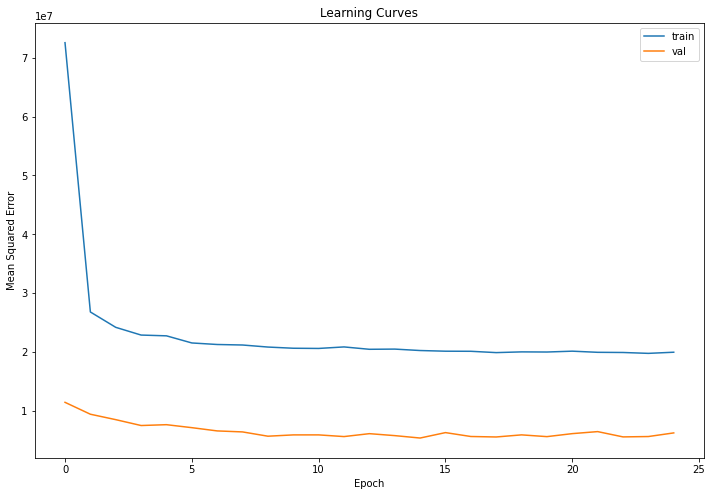

Train RMSE: 2464.752, Train MAPE: 14.302 

Val RMSE: 2409.618, Val MAPE: 14.237 

Test RMSE: 2428.999, Test MAPE: 14.386 

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_304 (Dense)            (None, 128)               6784      
_________________________________________________________________
dropout_136 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_305 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_137 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_306 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_138 (Dropout)        (None, 32)                0      

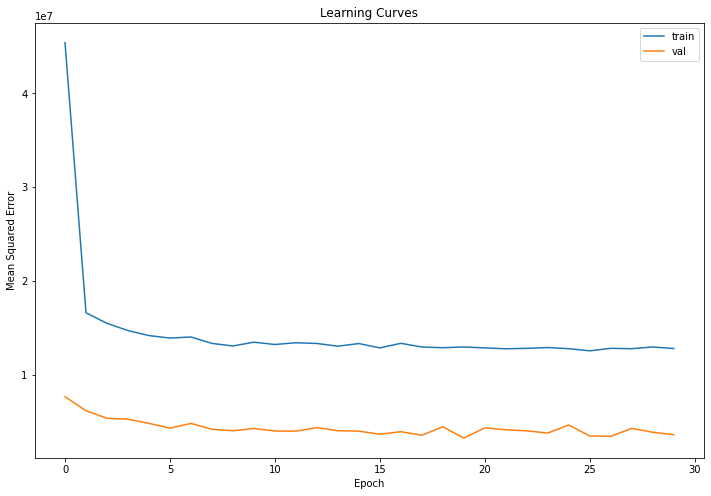

Train RMSE: 1859.448, Train MAPE: 10.388 

Val RMSE: 1825.774, Val MAPE: 10.356 

Test RMSE: 1836.767, Test MAPE: 10.474 

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_308 (Dense)            (None, 256)               13568     
_________________________________________________________________
dropout_139 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_309 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_140 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_310 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_141 (Dropout)        (None, 64)                0      

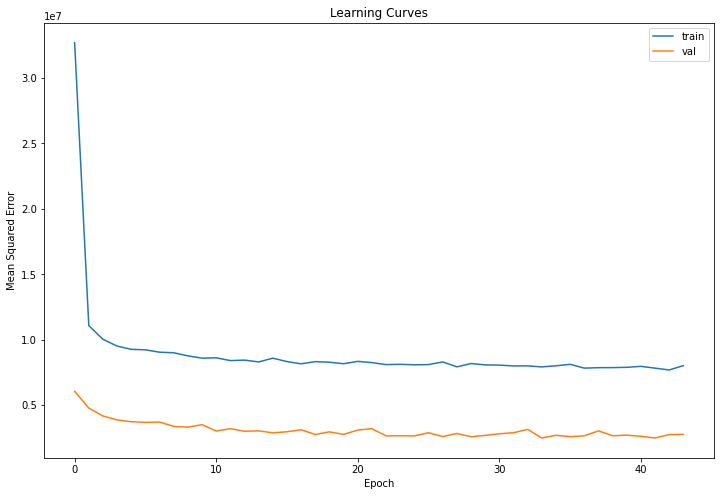

Train RMSE: 1627.502, Train MAPE: 8.989 

Val RMSE: 1620.546, Val MAPE: 9.076 

Test RMSE: 1619.991, Test MAPE: 9.132 

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_312 (Dense)            (None, 512)               27136     
_________________________________________________________________
dropout_142 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_313 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_143 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_314 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_144 (Dropout)        (None, 128)               0         

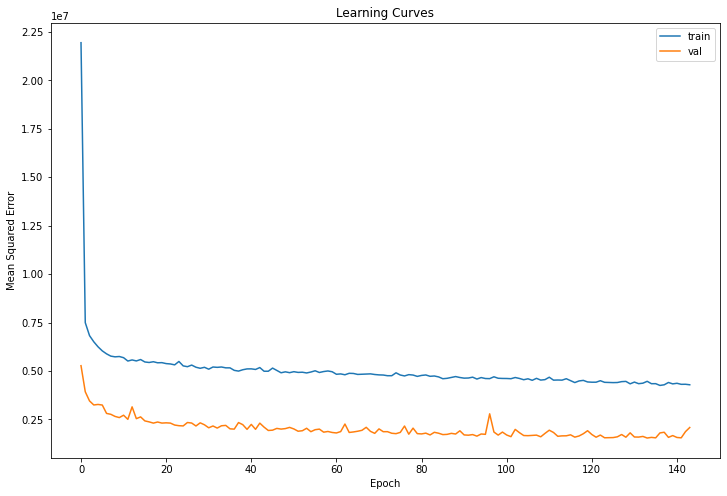

Train RMSE: 1386.940, Train MAPE: 7.638 

Val RMSE: 1396.695, Val MAPE: 7.789 

Test RMSE: 1400.544, Test MAPE: 7.863 

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_316 (Dense)            (None, 8)                 424       
_________________________________________________________________
dropout_145 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_317 (Dense)            (None, 16)                144       
_________________________________________________________________
dropout_146 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_318 (Dense)            (None, 8)                 136       
_________________________________________________________________
dropout_147 (Dropout)        (None, 8)                 0         

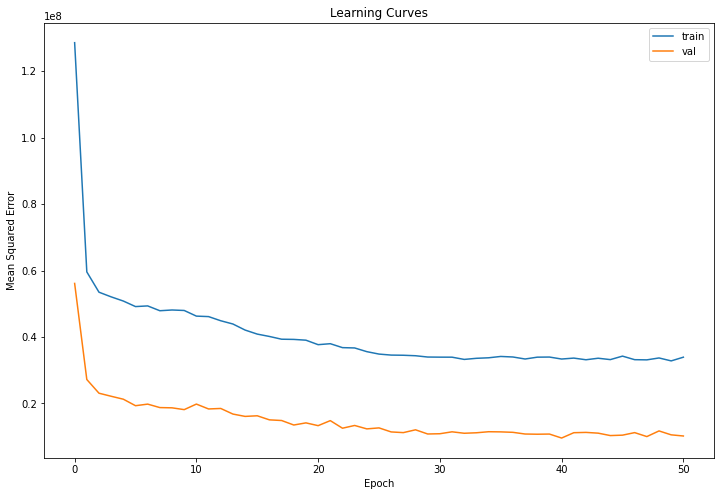

Train RMSE: 3175.310, Train MAPE: 17.568 

Val RMSE: 3117.301, Val MAPE: 17.485 

Test RMSE: 3135.181, Test MAPE: 17.682 

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_320 (Dense)            (None, 16)                848       
_________________________________________________________________
dropout_148 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_321 (Dense)            (None, 32)                544       
_________________________________________________________________
dropout_149 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_322 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_150 (Dropout)        (None, 16)                0      

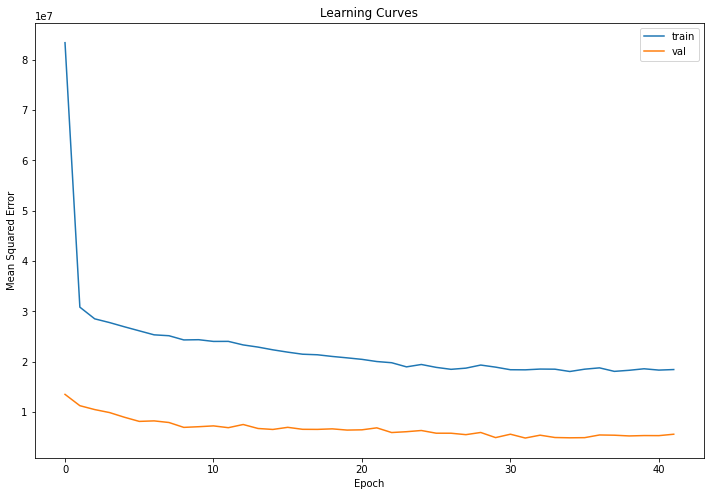

Train RMSE: 2345.253, Train MAPE: 12.851 

Val RMSE: 2289.145, Val MAPE: 12.800 

Test RMSE: 2305.613, Test MAPE: 12.956 

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_324 (Dense)            (None, 32)                1696      
_________________________________________________________________
dropout_151 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_325 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_152 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_326 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_153 (Dropout)        (None, 32)                0      

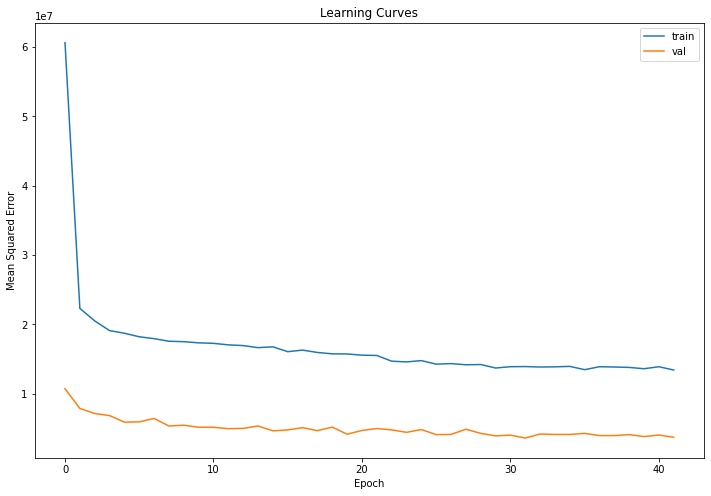

Train RMSE: 1909.483, Train MAPE: 10.614 

Val RMSE: 1863.683, Val MAPE: 10.531 

Test RMSE: 1876.140, Test MAPE: 10.706 

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_328 (Dense)            (None, 64)                3392      
_________________________________________________________________
dropout_154 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_329 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_155 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_330 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_156 (Dropout)        (None, 64)                0      

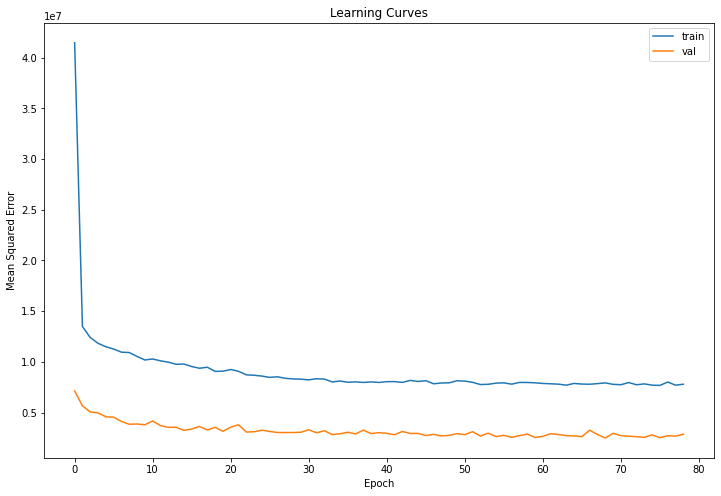

Train RMSE: 1658.885, Train MAPE: 9.403 

Val RMSE: 1638.238, Val MAPE: 9.422 

Test RMSE: 1632.034, Test MAPE: 9.524 

Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_332 (Dense)            (None, 128)               6784      
_________________________________________________________________
dropout_157 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_333 (Dense)            (None, 256)               33024     
_________________________________________________________________
dropout_158 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_334 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_159 (Dropout)        (None, 128)               0         

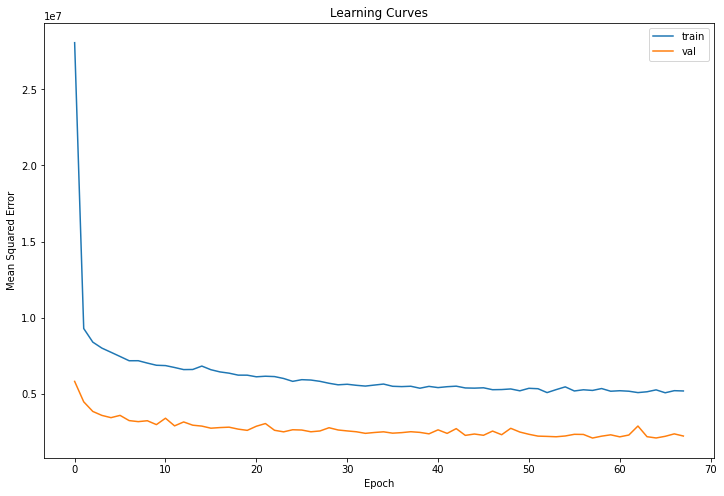

Train RMSE: 1457.940, Train MAPE: 8.447 

Val RMSE: 1457.460, Val MAPE: 8.457 

Test RMSE: 1449.964, Test MAPE: 8.614 

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_336 (Dense)            (None, 256)               13568     
_________________________________________________________________
dropout_160 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_337 (Dense)            (None, 512)               131584    
_________________________________________________________________
dropout_161 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_338 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_162 (Dropout)        (None, 256)               0         

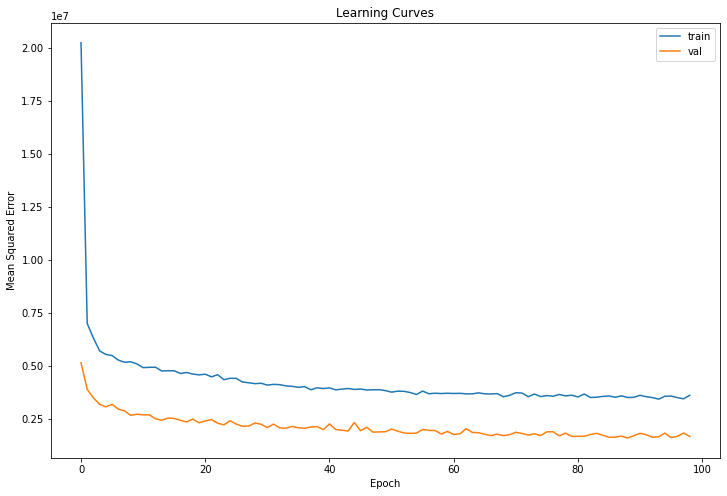

Train RMSE: 1246.999, Train MAPE: 7.260 

Val RMSE: 1278.067, Val MAPE: 7.377 

Test RMSE: 1268.124, Test MAPE: 7.449 

Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_340 (Dense)            (None, 8)                 424       
_________________________________________________________________
dropout_163 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_341 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_164 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_342 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_165 (Dropout)        (None, 8)                 0         

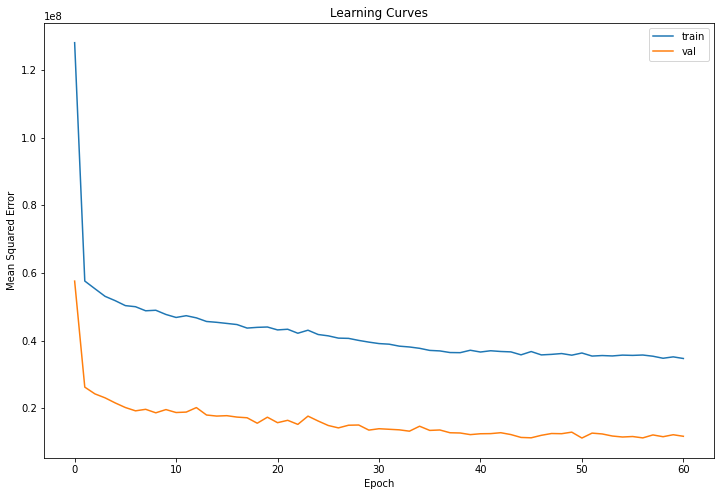

Train RMSE: 3397.988, Train MAPE: 19.441 

Val RMSE: 3342.981, Val MAPE: 19.343 

Test RMSE: 3360.169, Test MAPE: 19.549 

Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_344 (Dense)            (None, 16)                848       
_________________________________________________________________
dropout_166 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_345 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_167 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_346 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_168 (Dropout)        (None, 16)                0      

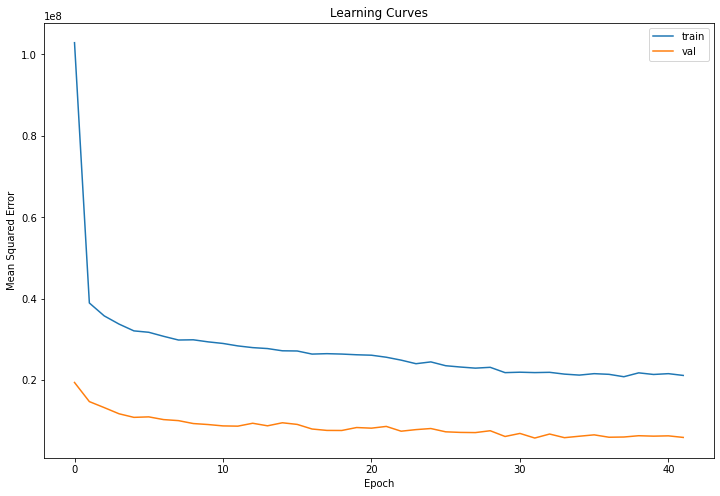

Train RMSE: 2419.020, Train MAPE: 13.072 

Val RMSE: 2357.770, Val MAPE: 12.959 

Test RMSE: 2373.210, Test MAPE: 13.153 

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_348 (Dense)            (None, 32)                1696      
_________________________________________________________________
dropout_169 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_349 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_170 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_350 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_171 (Dropout)        (None, 32)                0      

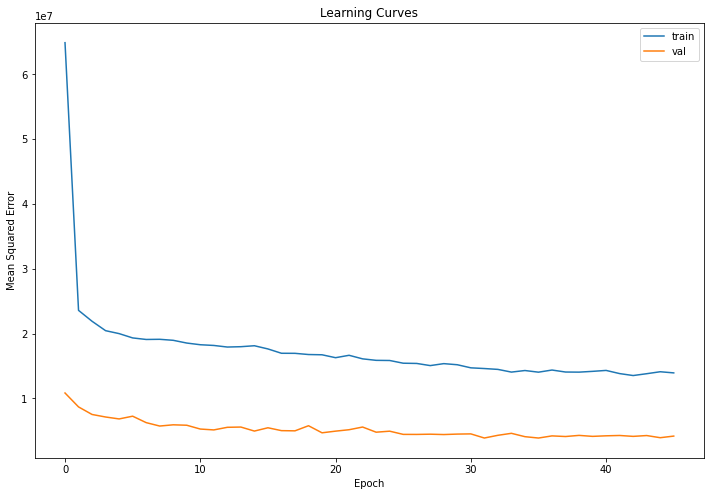

Train RMSE: 2017.875, Train MAPE: 11.058 

Val RMSE: 1971.350, Val MAPE: 10.990 

Test RMSE: 1981.772, Test MAPE: 11.153 

Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_352 (Dense)            (None, 64)                3392      
_________________________________________________________________
dropout_172 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_353 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_173 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_354 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_174 (Dropout)        (None, 64)                0      

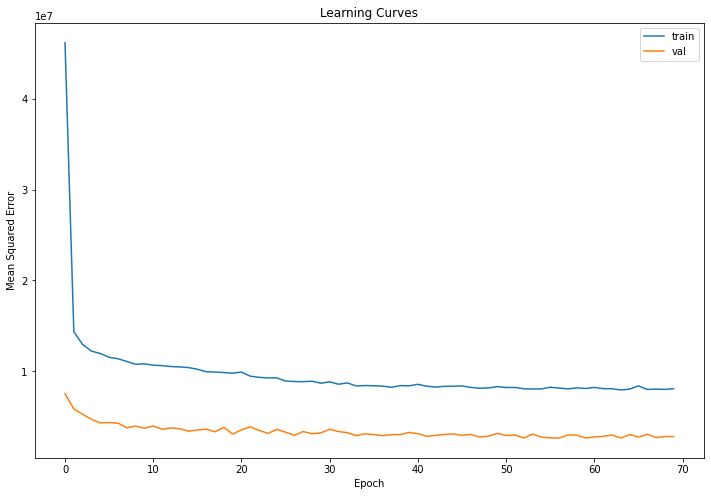

Train RMSE: 1640.911, Train MAPE: 9.377 

Val RMSE: 1617.132, Val MAPE: 9.416 

Test RMSE: 1619.042, Test MAPE: 9.534 

Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_356 (Dense)            (None, 128)               6784      
_________________________________________________________________
dropout_175 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_357 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_176 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_358 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_177 (Dropout)        (None, 128)               0         

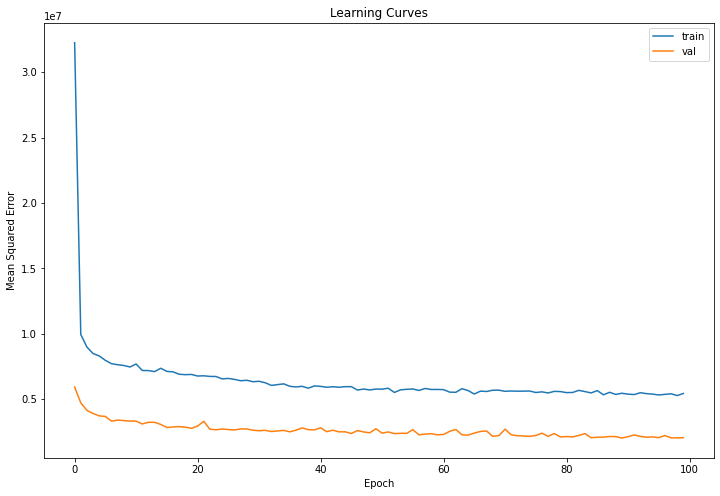

Train RMSE: 1397.272, Train MAPE: 8.312 

Val RMSE: 1408.910, Val MAPE: 8.353 

Test RMSE: 1399.673, Test MAPE: 8.436 

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_360 (Dense)            (None, 256)               13568     
_________________________________________________________________
dropout_178 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_361 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_179 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_362 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_180 (Dropout)        (None, 256)               0         

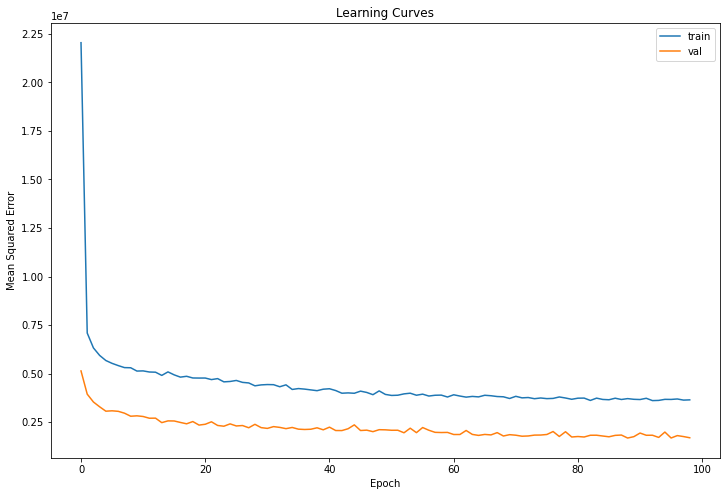

Train RMSE: 1253.497, Train MAPE: 7.552 

Val RMSE: 1290.073, Val MAPE: 7.627 

Test RMSE: 1286.178, Test MAPE: 7.752 

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_364 (Dense)            (None, 512)               27136     
_________________________________________________________________
dropout_181 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_365 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_182 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_366 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_183 (Dropout)        (None, 512)               0         

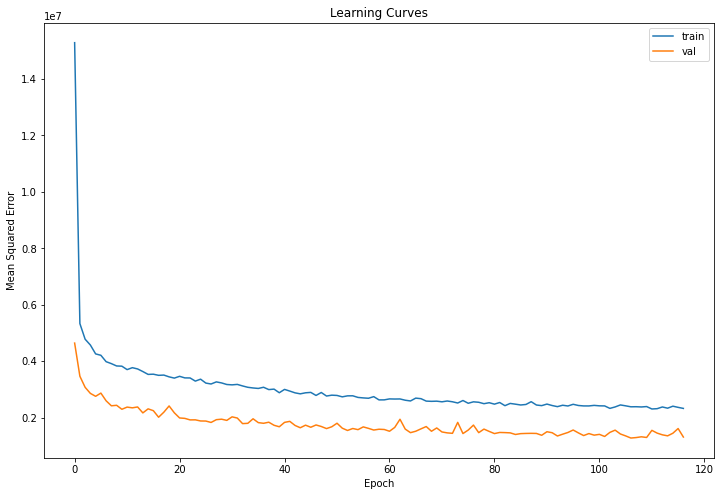

Train RMSE: 1046.211, Train MAPE: 6.320 

Val RMSE: 1091.080, Val MAPE: 6.584 

Test RMSE: 1089.116, Test MAPE: 6.652 



,n_layer1,n_layer2,n_layer3,batch_norm,drop_rate,train_rmse,eval_rmse,test_rmse,train_mape,eval_mape,test_mape
0,8,16,32,"(True, True)",0.5,1836.610107,1804.718872,1823.603882,10.609259,10.622742,10.738523
1,16,32,64,"(True, True)",0.5,1619.172241,1635.080933,1607.217651,8.767266,8.857787,8.912285
2,32,64,128,"(True, True)",0.5,1235.133301,1284.968384,1280.727051,7.574786,7.778414,7.873955
3,64,128,256,"(True, True)",0.5,1259.214600,1343.467285,1605.730713,7.059783,7.210831,7.299235
4,128,256,512,"(True, True)",0.5,974.705017,1031.840942,1057.164917,5.693451,6.019894,6.051782
...,...,...,...,...,...,...,...,...,...,...,...
87,32,32,32,"(False, False)",0.5,2017.874512,1971.349609,1981.771606,11.058054,10.989768,11.153302
88,64,64,64,"(False, False)",0.5,1640.911133,1617.131714,1619.041626,9.376785,9.416217,9.534481
89,128,128,128,"(False, False)",0.5,1397.272461,1408.910034,1399.673218,8.311769,8.352872,8.436033
90,256,256,256,"(False, False)",0.5,1253.497192,1290.072754,1286.177612,7.551811,7.626603,7.751887


<Figure size 864x576 with 0 Axes>

In [11]:
df_results = pd.DataFrame()

param_grid = [(x, y) for x in [True, False] for y in [True, False]] # searching for best batch_norm and dropout_rate

for norm_vals in tqdm(param_grid):
    frame = model_training(batch_norm=norm_vals, drop_rate=0.5)
    df_results = pd.concat([df_results, frame], axis=0)
    
df_results.reset_index(drop=True, inplace=True)
df_results

# Saving Results

In [12]:
df_results.to_csv('three_layer_nn_results.csv', index=False)